In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import make_scorer, f1_score, precision_score,accuracy_score, recall_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score


In [2]:
selected_ticker = ['SNA','VICI','UHS','BWA','MRO']
df_dict = {}
for i in selected_ticker:
    df_dict[i] = pd.read_csv(f'./stock_dfs2/{i}_2.csv')

In [ ]:


def add_feature(f):

    f['price_diff'] = f['Close'].diff()
    f['label'] = 0
    
    # Assign labels based on the direction of the price change
    f.loc[f['price_diff'] > 0, 'label'] = 1  # Price went up
    f.loc[f['price_diff'] < 0, 'label'] = 0  # Price went down
    f.drop(columns=['price_diff'], inplace=True)
    
    return f
def gambar(f,target='label'):
    f['Date'] = pd.to_datetime(f['Date'], utc=True)
    plt.figure(figsize=(12, 6))
    plt.plot(f['Date'], f['Close'], label='Close Price', color='black')
    plt.scatter(f['Date'][f[target] == 0], f['Close'][f[target] == 0], 
               color='green', label='Label 0 (Beli / Harga turun)', marker='o')
    plt.scatter(f['Date'][f[target] == 1], f['Close'][f[target] == 1], 
               color='red', label='Label 1 (Jual / Harga naik)', marker='o')

    plt.title('Price Chart with Labels')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()


In [5]:
def add_technical_indicators(df, window=10):
    df = df.copy()
    
    df['SMA'] = df['Close'].rolling(window=window).mean()
    
    weights = np.arange(1, window + 1)
    df['WMA'] = df['Close'].rolling(window).apply(
        lambda x: np.dot(x, weights) / weights.sum(), raw=True
    )
    
    df['Momentum'] = df['Close'].diff(window)
    
    low_min = df['Low'].rolling(window=window).min()
    high_max = df['High'].rolling(window=window).max()
    df['Stochastic_K'] = ((df['Close'] - low_min) / (high_max - low_min)) * 100
    
    df['Stochastic_D'] = df['Stochastic_K'].rolling(window=window).mean()
    
    change = df['Close'].diff(1)
    gain = (change.where(change > 0, 0)).rolling(window=window).mean()
    loss = (-change.where(change < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    df['Williams_R'] = ((high_max - df['Close']) / (high_max - low_min)) * -100
    
    df['A/D_Oscillator'] = ((df['High'] - df['Close'].shift(1)) / 
                           (df['High'] - df['Low']))
    
    mean_deviation = lambda x: np.mean(np.abs(x - np.mean(x)))
    df['CCI'] = ((df['Close'] - df['Close'].rolling(window=window).mean()) / 
                 (0.015 * df['Close'].rolling(window=window).apply(mean_deviation, raw=True)))
    
    return df

def add_date_features(df):
    if 'Date' not in df.columns:
        raise ValueError("DataFrame harus mengandung kolom 'Date'.")
    if not pd.api.types.is_datetime64_any_dtype(df['Date']):
        raise TypeError("Kolom 'Date' harus bertipe datetime.")

    # Menambahkan kolom 'day' yang berisi hari dalam bulan
    df['day'] = df['Date'].dt.day

    # Menambahkan kolom 'day_of_week' yang berisi hari dalam minggu (0=Senin, 6=Minggu)
    df['day_of_week'] = df['Date'].dt.dayofweek

    # Menambahkan kolom 'month' yang berisi bulan
    df['month'] = df['Date'].dt.month

    # Menambahkan kolom 'year' yang berisi tahun
    df['year'] = df['Date'].dt.year

    return df

features = ['SMA', 'WMA',
       'Momentum', 'Stochastic_K', 'Stochastic_D', 'RSI', 'MACD',
       'MACD_Signal', 'Williams_R', 'A/D_Oscillator', 'CCI']

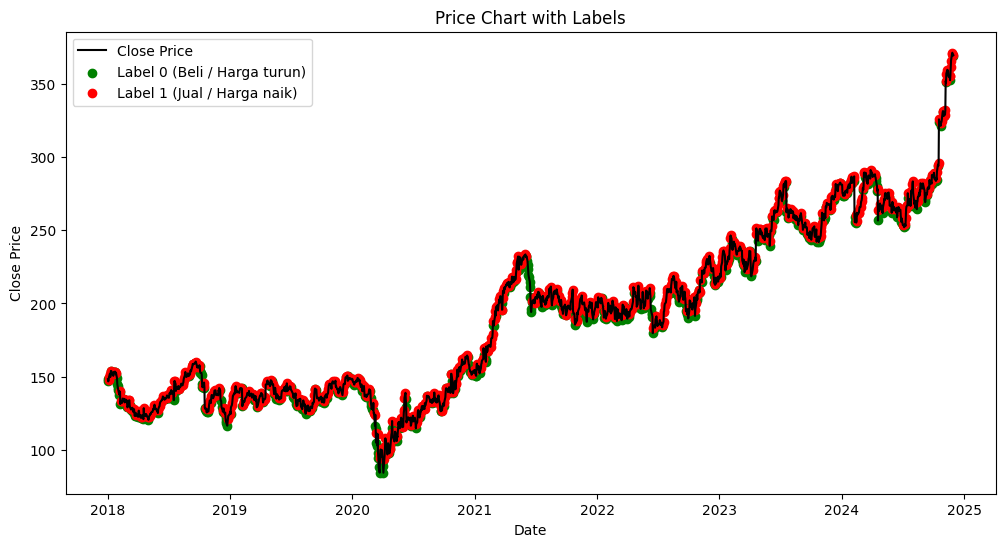

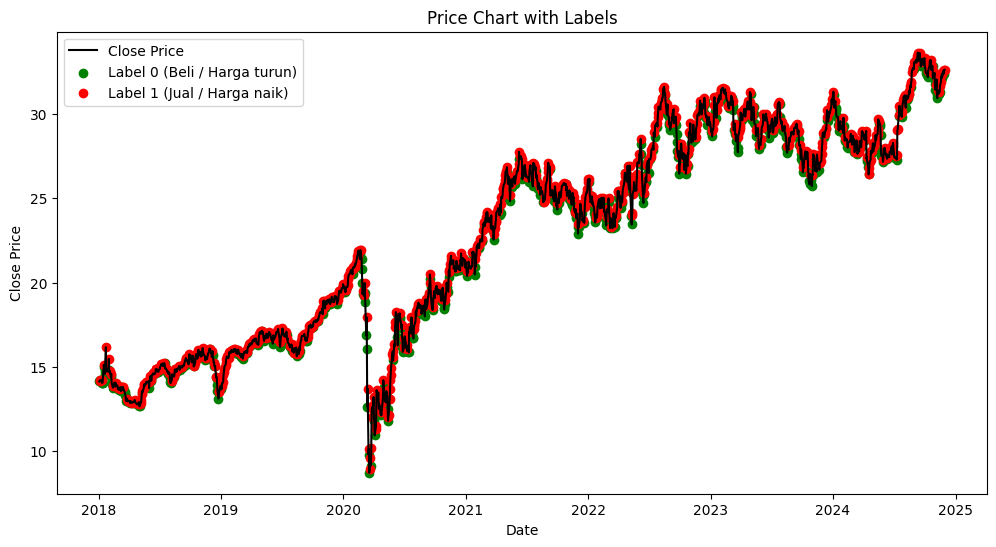

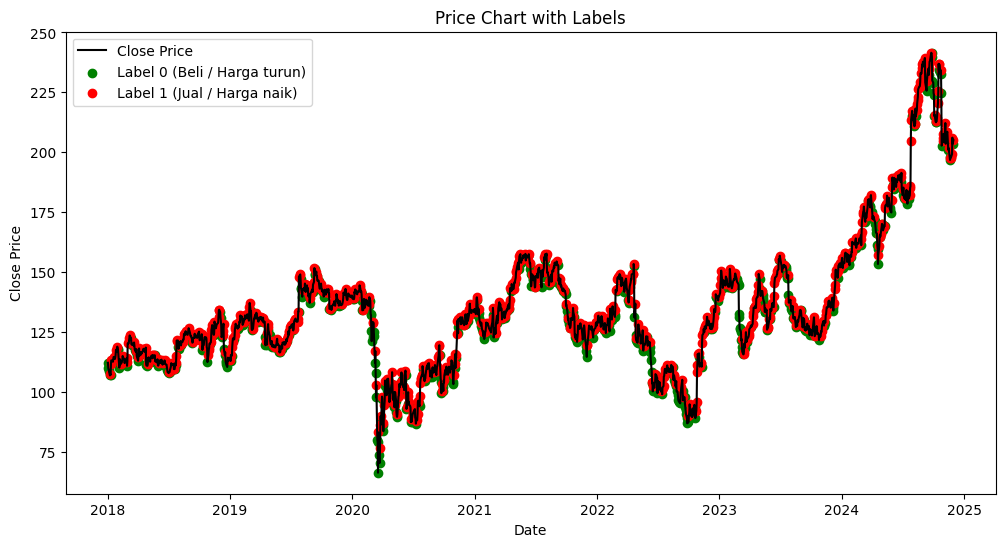

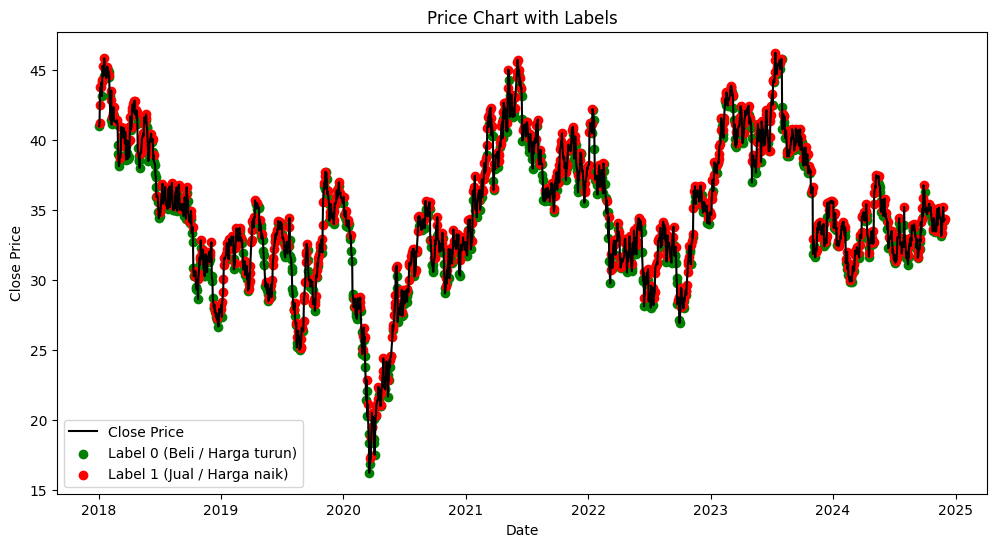

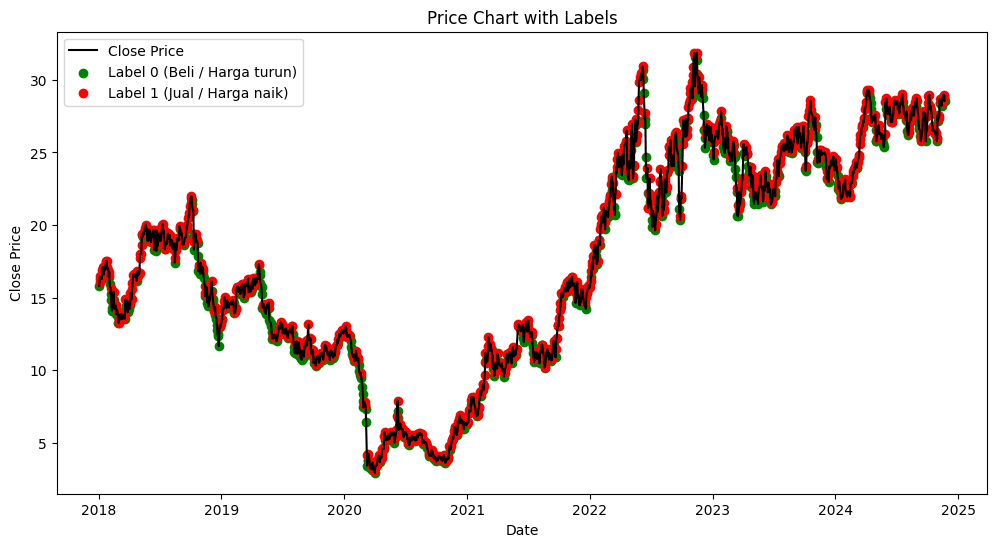

In [6]:
for i in df_dict:
    df_dict[i]['Date'] = pd.to_datetime(df_dict[i]['Date'],utc=True)
    df_dict[i] = add_feature(df_dict[i])
    df_dict[i] = add_date_features(df_dict[i])
    df_dict[i] = add_technical_indicators(df_dict[i])
    gambar(df_dict[i])

# 1. SNA

In [3]:
df_dict['SNA']

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2018-01-02 00:00:00-05:00,146.242915,148.345498,144.324611,148.177963,727700,0.0,0.0
1,2018-01-03 00:00:00-05:00,148.002125,148.253433,145.480698,146.753983,434800,0.0,0.0
2,2018-01-04 00:00:00-05:00,147.331952,148.127750,146.645045,147.574875,432400,0.0,0.0
3,2018-01-05 00:00:00-05:00,148.043999,149.677481,147.667043,149.484818,407800,0.0,0.0
4,2018-01-08 00:00:00-05:00,149.208355,152.198894,148.739253,152.014603,1454300,0.0,0.0
...,...,...,...,...,...,...,...,...
1735,2024-11-22 00:00:00-05:00,362.140015,367.119995,361.070007,365.970001,593000,0.0,0.0
1736,2024-11-25 00:00:00-05:00,367.500000,372.940002,367.500000,370.640015,584300,0.0,0.0
1737,2024-11-26 00:00:00-05:00,369.010010,372.029999,367.660004,371.350006,442500,0.0,0.0
1738,2024-11-27 00:00:00-05:00,371.920013,373.899994,369.010010,369.230011,273000,0.0,0.0


In [35]:
X_train = df_dict['SNA'].dropna(subset=features)
split_fraction = 0.8
split_index = int(len(X_train) * split_fraction)
train_set = X_train.iloc[:split_index]
test_set = X_train.iloc[split_index:]

In [19]:
test_set

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,label,day,...,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
1395,2023-07-20 04:00:00+00:00,279.533987,280.755195,261.898416,262.263824,714200,0.0,0.0,0,20,...,278.110666,-8.144684,1.526120,73.659894,39.802519,4.822113,6.079215,-98.473880,-0.119327,-192.150818
1396,2023-07-21 04:00:00+00:00,263.360074,266.658318,260.667607,264.965912,383800,0.0,0.0,1,21,...,275.749875,-4.981079,17.074080,70.305133,44.094799,3.577858,5.578943,-82.925920,0.733551,-135.578058
1397,2023-07-24 04:00:00+00:00,265.715946,266.985251,263.340820,264.062012,283400,0.0,0.0,0,24,...,273.315304,-10.365936,13.483534,64.290865,36.572029,2.490135,4.961182,-86.516466,0.554089,-108.493132
1398,2023-07-25 04:00:00+00:00,264.898657,265.158276,262.427365,262.638916,226400,0.0,0.0,0,25,...,270.810459,-17.375885,7.830597,55.229073,24.769686,1.496029,4.268151,-92.169403,0.401428,-89.613867
1399,2023-07-26 04:00:00+00:00,261.311881,263.071577,258.542500,258.667511,303900,0.0,0.0,0,26,...,267.899466,-22.847382,0.457924,46.329250,19.046398,0.383315,3.491184,-99.542076,0.095530,-92.676257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,2024-11-22 05:00:00+00:00,362.140015,367.119995,361.070007,365.970001,593000,0.0,0.0,1,22,...,358.326639,8.848633,93.323743,79.016013,67.453320,13.134609,13.699128,-6.676257,0.945457,179.009024
1736,2024-11-25 05:00:00+00:00,367.500000,372.940002,367.500000,370.640015,584300,0.0,0.0,1,25,...,360.653248,10.954041,90.019639,78.373148,69.949202,13.459408,13.651184,-9.980361,1.281250,182.656989
1737,2024-11-26 05:00:00+00:00,369.010010,372.029999,367.660004,371.350006,442500,0.0,0.0,1,26,...,362.909782,13.155060,93.100513,78.503038,74.659143,13.617135,13.644374,-6.899487,0.318075,130.495873
1738,2024-11-27 05:00:00+00:00,371.920013,373.899994,369.010010,369.230011,273000,0.0,0.0,0,27,...,364.541680,10.130524,80.545895,77.576053,68.162057,13.416413,13.598782,-19.454105,0.521472,82.293715


In [16]:
ChoosenFeature = ['A/D_Oscillator', 'CCI', 'month', 'Stochastic_K', 'Williams_R', 'day', 'SMA', 'Open', 'Close', 'Low', 'High', 'MACD_Signal', 'WMA', 'Stochastic_D', 'RSI']

In [20]:
y_train_SNA = train_set['label']  
X_train_SNA = train_set.drop(columns=['label','Date','Dividends','Stock Splits'])
X_train_SNA  = X_train_SNA[ChoosenFeature]

In [28]:
y_test_SNA = test_set['label']  
X_test_SNA = test_set.drop(columns=['label','Date','Dividends','Stock Splits'])
X_test_SNA  = X_test_SNA[ChoosenFeature]

In [24]:
X_train_SNA

,A/D_Oscillator,CCI,month,Stochastic_K,Williams_R,day,SMA,Open,Close,Low,High,MACD_Signal,WMA,Stochastic_D,RSI
18,-0.208579,-178.014497,1,2.482846,-97.517154,29,151.976062,150.783167,149.032410,148.881620,152.014564,1.003581,151.896255,52.601406,32.469000
19,-0.372902,-227.220530,1,12.381709,-87.618291,30,151.324345,147.533019,144.827301,143.512143,147.533019,0.841929,150.596480,47.481436,28.743160
20,0.443466,-164.987183,1,2.609339,-97.390661,31,150.498392,145.673323,143.503723,143.218913,146.108922,0.597583,149.174549,41.386493,24.561557
21,0.142846,-129.115829,2,4.915893,-95.084107,1,149.670760,142.481723,142.305817,141.694298,143.805266,0.293742,147.684990,37.363224,24.536189
22,-0.090601,-115.753493,2,7.890263,-92.109737,2,148.422610,141.258746,140.638855,139.482846,142.071301,-0.058727,146.042826,31.068479,9.422712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390,0.037850,79.791599,7,74.882471,-25.117529,13,275.745334,280.985993,279.428223,278.582019,281.630270,6.075637,276.540136,79.230830,63.878506
1391,0.703504,98.765129,7,90.799161,-9.200839,14,276.322290,278.985899,281.707184,278.370468,281.937985,6.154566,277.624109,78.376862,61.876529
1392,0.749133,101.314929,7,85.970840,-14.029160,17,276.954056,281.630287,283.438080,280.322510,285.842053,6.248625,278.917889,77.646214,62.717797
1393,0.615969,85.663160,7,87.822495,-12.177505,18,277.745444,283.197662,283.755371,282.005272,285.736243,6.338058,280.154492,77.799269,66.572722


In [25]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(C=10, penalty='l1', solver='liblinear'))
])

pipeline.fit(X_train_SNA, y_train_SNA)

y_test_SNA = test_set['label']
X_test_SNA = test_set.drop(columns=['label','Date','Dividends','Stock Splits'])
X_test_SNA = X_test_SNA[ChoosenFeature]

y_pred = pipeline.predict(X_test_SNA)

accuracy = accuracy_score(y_test_SNA, y_pred)
precision = precision_score(y_test_SNA, y_pred)
recall = recall_score(y_test_SNA, y_pred)
f1 = f1_score(y_test_SNA, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.9652173913043478
Precision: 0.9781420765027322
Recall: 0.9572192513368984
F1 Score: 0.9675675675675676


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Menggunakan data test sebagai backtest

In [36]:
hasil = test_set.copy()
hasil['Predict_Label'] = y_pred
print(hasil)

                          Date        Open        High         Low  \
1395 2023-07-20 04:00:00+00:00  279.533987  280.755195  261.898416   
1396 2023-07-21 04:00:00+00:00  263.360074  266.658318  260.667607   
1397 2023-07-24 04:00:00+00:00  265.715946  266.985251  263.340820   
1398 2023-07-25 04:00:00+00:00  264.898657  265.158276  262.427365   
1399 2023-07-26 04:00:00+00:00  261.311881  263.071577  258.542500   
...                        ...         ...         ...         ...   
1735 2024-11-22 05:00:00+00:00  362.140015  367.119995  361.070007   
1736 2024-11-25 05:00:00+00:00  367.500000  372.940002  367.500000   
1737 2024-11-26 05:00:00+00:00  369.010010  372.029999  367.660004   
1738 2024-11-27 05:00:00+00:00  371.920013  373.899994  369.010010   
1739 2024-11-29 05:00:00+00:00  369.230011  371.980011  369.109985   

           Close  Volume  Dividends  Stock Splits  label  day  ...   Momentum  \
1395  262.263824  714200        0.0           0.0      0   20  ...  -8.144684 

### Label asli VS Prediction

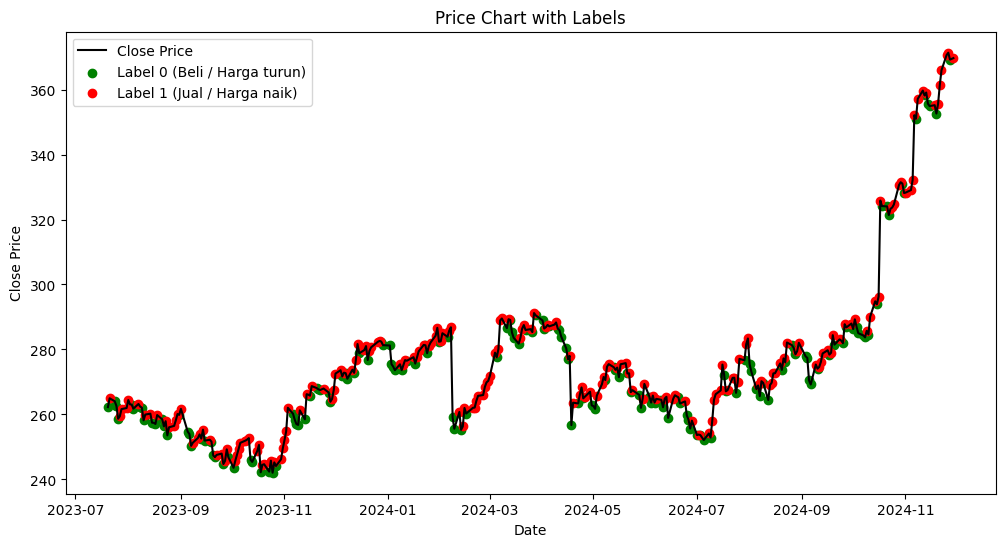

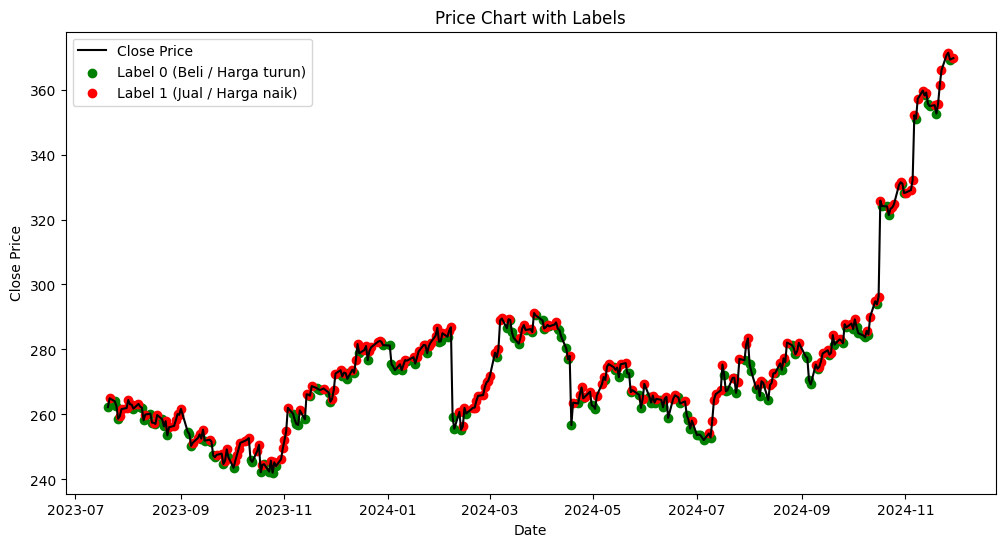

In [38]:
gambar(hasil)
gambar(hasil,'Predict_Label')

## Transform into local minima/maxima

In [40]:
for i in range(len(y_pred)-1):
    if y_pred[i] == y_pred[i+1]:
        y_pred[i] = 2 # hold

### Predict Label vs Local Maxima/Minima

                          Date        Open        High         Low  \
1395 2023-07-20 04:00:00+00:00  279.533987  280.755195  261.898416   
1396 2023-07-21 04:00:00+00:00  263.360074  266.658318  260.667607   
1397 2023-07-24 04:00:00+00:00  265.715946  266.985251  263.340820   
1398 2023-07-25 04:00:00+00:00  264.898657  265.158276  262.427365   
1399 2023-07-26 04:00:00+00:00  261.311881  263.071577  258.542500   
...                        ...         ...         ...         ...   
1735 2024-11-22 05:00:00+00:00  362.140015  367.119995  361.070007   
1736 2024-11-25 05:00:00+00:00  367.500000  372.940002  367.500000   
1737 2024-11-26 05:00:00+00:00  369.010010  372.029999  367.660004   
1738 2024-11-27 05:00:00+00:00  371.920013  373.899994  369.010010   
1739 2024-11-29 05:00:00+00:00  369.230011  371.980011  369.109985   

           Close  Volume  Dividends  Stock Splits  label  day  ...   Momentum  \
1395  262.263824  714200        0.0           0.0      0   20  ...  -8.144684 

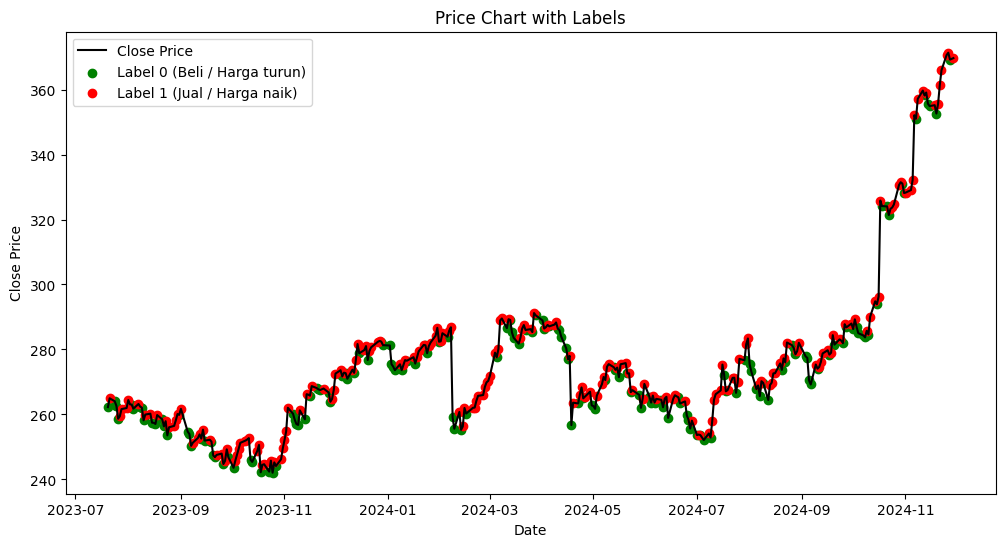

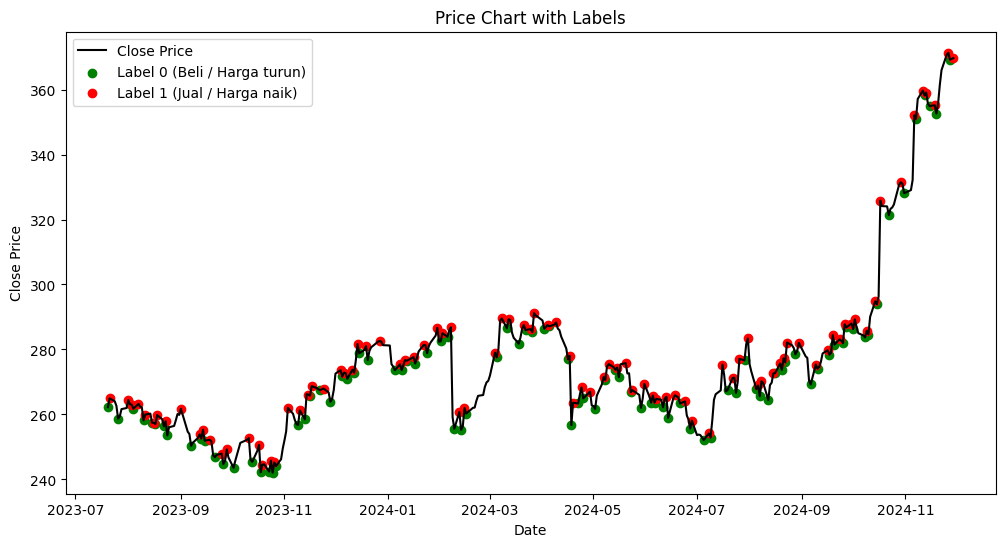

In [41]:
hasil_2 = test_set.copy()
hasil_2['Predict_Label'] = y_pred
print(hasil_2)
gambar(hasil_2)
gambar(hasil_2,'Predict_Label')

## Backtesting Algorithm

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def trading_simulation(df, initial_capital=100000):
    capital = initial_capital
    shares = 0
    transactions = []
    wealth_history = []
    fee_rate = 0.0004  # 0.04%
    
    for i in range(len(df)):
        current_price =  df['Close'].iloc[i]
        action = df['Predict_Label'].iloc[i]
        
        total_wealth = capital + (shares * current_price)
        wealth_history.append({
            'Date': df.index[i],
            'Wealth': total_wealth,
            'Cash': capital,
            'Stock Value': shares * current_price
        })
        
        if action == 0:  # Beli
            buy_amount = initial_capital * 0.3  # 30% dari modal awal
            if capital >= buy_amount:
                shares_to_buy = (buy_amount // current_price)
                cost = shares_to_buy * current_price
                fee = cost * fee_rate
                total_cost = cost + fee
                
                if total_cost <= capital:
                    capital -= total_cost
                    shares += shares_to_buy
                    transactions.append({
                        'Date': df.index[i],
                        'Action': 'Beli',
                        'Shares': shares_to_buy,
                        'Price': current_price,
                        'Cost': cost,
                        'Fee': fee,
                        'Total Cost': total_cost,
                        'Remaining Capital': capital,
                        'Total Shares': shares
                    })
                
        elif action == 1:  # Jual
            if shares > 0:
                revenue = shares * current_price
                fee = revenue * fee_rate
                net_revenue = revenue - fee
                capital += net_revenue
                transactions.append({
                    'Date': df.index[i],
                    'Action': 'Jual',
                    'Shares': shares,
                    'Price': current_price,
                    'Revenue': revenue,
                    'Fee': fee,
                    'Net Revenue': net_revenue,
                    'Remaining Capital': capital,
                    'Total Shares': 0
                })
                shares = 0
    
    # Hitung total aset di akhir periode
    final_portfolio_value = capital + (shares * df['Close'].iloc[-1])
    
    return (pd.DataFrame(transactions), 
            pd.DataFrame(wealth_history), 
            final_portfolio_value)


In [44]:
hasil_2

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,label,day,...,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI,Predict_Label
1395,2023-07-20 04:00:00+00:00,279.533987,280.755195,261.898416,262.263824,714200,0.0,0.0,0,20,...,-8.144684,1.526120,73.659894,39.802519,4.822113,6.079215,-98.473880,-0.119327,-192.150818,0
1396,2023-07-21 04:00:00+00:00,263.360074,266.658318,260.667607,264.965912,383800,0.0,0.0,1,21,...,-4.981079,17.074080,70.305133,44.094799,3.577858,5.578943,-82.925920,0.733551,-135.578058,1
1397,2023-07-24 04:00:00+00:00,265.715946,266.985251,263.340820,264.062012,283400,0.0,0.0,0,24,...,-10.365936,13.483534,64.290865,36.572029,2.490135,4.961182,-86.516466,0.554089,-108.493132,2
1398,2023-07-25 04:00:00+00:00,264.898657,265.158276,262.427365,262.638916,226400,0.0,0.0,0,25,...,-17.375885,7.830597,55.229073,24.769686,1.496029,4.268151,-92.169403,0.401428,-89.613867,2
1399,2023-07-26 04:00:00+00:00,261.311881,263.071577,258.542500,258.667511,303900,0.0,0.0,0,26,...,-22.847382,0.457924,46.329250,19.046398,0.383315,3.491184,-99.542076,0.095530,-92.676257,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,2024-11-22 05:00:00+00:00,362.140015,367.119995,361.070007,365.970001,593000,0.0,0.0,1,22,...,8.848633,93.323743,79.016013,67.453320,13.134609,13.699128,-6.676257,0.945457,179.009024,2
1736,2024-11-25 05:00:00+00:00,367.500000,372.940002,367.500000,370.640015,584300,0.0,0.0,1,25,...,10.954041,90.019639,78.373148,69.949202,13.459408,13.651184,-9.980361,1.281250,182.656989,2
1737,2024-11-26 05:00:00+00:00,369.010010,372.029999,367.660004,371.350006,442500,0.0,0.0,1,26,...,13.155060,93.100513,78.503038,74.659143,13.617135,13.644374,-6.899487,0.318075,130.495873,1
1738,2024-11-27 05:00:00+00:00,371.920013,373.899994,369.010010,369.230011,273000,0.0,0.0,0,27,...,10.130524,80.545895,77.576053,68.162057,13.416413,13.598782,-19.454105,0.521472,82.293715,0



Riwayat Transaksi:
     Date Action  Shares       Price          Cost        Fee    Total Cost  \
0    1395   Beli   114.0  262.263824  29898.075989  11.959230  29910.035219   
1    1396   Jual   114.0  264.965912           NaN  12.082446           NaN   
2    1399   Beli   115.0  258.667511  29746.763763  11.898706  29758.662469   
3    1403   Jual   115.0  264.437012           NaN  12.164103           NaN   
4    1404   Beli   114.0  263.110046  29994.545288  11.997818  30006.543106   
..    ...    ...     ...         ...           ...        ...           ...   
179  1731   Jual    84.0  355.202942           NaN  11.934819           NaN   
180  1732   Beli    85.0  352.618469  29972.569885  11.989028  29984.558913   
181  1737   Jual    85.0  371.350006           NaN  12.625900           NaN   
182  1738   Beli    81.0  369.230011  29907.630890  11.963052  29919.593942   
183  1739   Jual    81.0  369.690002           NaN  11.977956           NaN   

     Remaining Capital  Total S

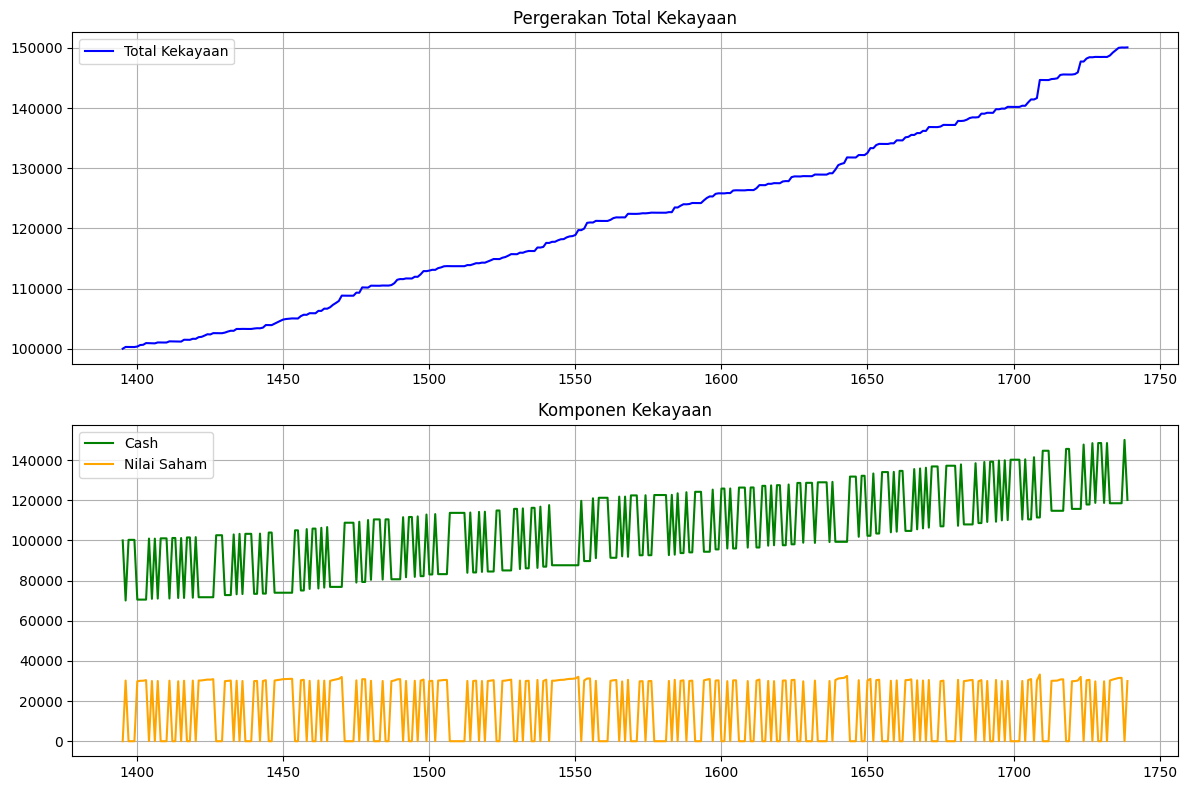


Total Return: 50.07%
Jumlah Transaksi: 184
Total Fee: USD 2,218.27


In [ ]:
initial_capital = 100000
transactions, wealth_history, final_value = trading_simulation(hasil_2, initial_capital)

print("\nRiwayat Transaksi:")
print(transactions)
print(f"\nNilai Portfolio Akhir: USD {final_value:,.2f}")

plt.figure(figsize=(12, 8))


plt.subplot(2, 1, 1)
plt.plot(wealth_history['Date'], wealth_history['Wealth'], label='Total Kekayaan', color='blue')
plt.title('Pergerakan Total Kekayaan')
plt.grid(True)
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(wealth_history['Date'], wealth_history['Cash'], label='Cash', color='green')
plt.plot(wealth_history['Date'], wealth_history['Stock Value'], label='Nilai Saham', color='orange')
plt.title('Komponen Kekayaan')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

total_return = (final_value - initial_capital) / initial_capital * 100
print(f"\nTotal Return: {total_return:.2f}%")

total_transactions = len(transactions)
total_fees = transactions['Fee'].sum() if not transactions.empty else 0
print(f"Jumlah Transaksi: {total_transactions}")
print(f"Total Fee: USD {total_fees:,.2f}")


# 2. VICI

In [51]:
df_dict['VICI']

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,label,day,...,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
0,2018-01-02 05:00:00+00:00,14.061208,14.483045,14.026056,14.131515,427900,0.0,0.0,0,2,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
1,2018-01-03 05:00:00+00:00,14.412739,14.483045,14.061209,14.173698,231300,0.0,0.0,1,3,...,NaN,NaN,NaN,NaN,NaN,0.003365,0.000673,NaN,0.833334,NaN
2,2018-01-04 05:00:00+00:00,14.166670,14.412742,14.131518,14.201824,447800,0.0,0.0,1,4,...,NaN,NaN,NaN,NaN,NaN,0.008207,0.002180,NaN,0.850011,NaN
3,2018-01-05 05:00:00+00:00,14.201824,14.201824,14.166670,14.201824,78300,0.0,0.0,0,5,...,NaN,NaN,NaN,NaN,NaN,0.011907,0.004125,NaN,0.000000,NaN
4,2018-01-08 05:00:00+00:00,14.201824,14.201824,14.096364,14.201824,59200,0.0,0.0,0,8,...,NaN,NaN,NaN,NaN,NaN,0.014670,0.006234,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,2024-11-22 05:00:00+00:00,32.500000,32.599998,32.139999,32.230000,3346500,0.0,0.0,0,22,...,31.975091,0.840000,77.018681,61.809667,74.418592,-0.070297,-0.206302,-22.981319,0.500000,77.149873
1736,2024-11-25 05:00:00+00:00,32.259998,32.705002,32.240002,32.529999,6375900,0.0,0.0,1,25,...,32.115272,1.249998,89.795753,68.050109,82.722433,-0.015963,-0.168234,-10.204247,1.021510,104.734024
1737,2024-11-26 05:00:00+00:00,32.459999,32.529999,32.320000,32.380001,3589500,0.0,0.0,0,26,...,32.205454,1.180000,81.049541,73.763754,79.797994,0.014823,-0.131623,-18.950459,0.000000,68.553011
1738,2024-11-27 05:00:00+00:00,32.450001,32.875000,32.439999,32.599998,4634200,0.0,0.0,1,27,...,32.314181,1.289999,85.411061,78.617709,80.861246,0.056324,-0.094034,-14.588939,1.137925,101.251882


In [52]:
X_train = df_dict['VICI'].dropna(subset=features)
split_fraction = 0.8
split_index = int(len(X_train) * split_fraction)
train_set = X_train.iloc[:split_index]
test_set = X_train.iloc[split_index:]

In [53]:
test_set

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,label,day,...,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
1395,2023-07-20 04:00:00+00:00,30.143128,30.558541,29.797728,30.535202,6134100,0.0,0.0,1,20,...,29.750374,1.652315,98.721150,67.123487,81.052567,0.157755,0.050557,-1.278850,0.717789,196.428125
1396,2023-07-21 04:00:00+00:00,30.703234,30.717236,30.390508,30.609884,4616800,0.0,0.0,1,21,...,29.931984,1.549633,94.292901,72.517711,80.291938,0.222422,0.084930,-5.707099,0.557143,149.470736
1397,2023-07-24 04:00:00+00:00,30.693899,30.889936,30.488525,30.693899,5888400,0.0,0.0,1,24,...,30.100695,1.260239,89.655212,75.108960,77.777694,0.277254,0.123395,-10.344788,0.697669,117.061715
1398,2023-07-25 04:00:00+00:00,30.805925,30.819927,30.549207,30.656563,4918600,0.0,0.0,0,25,...,30.239704,0.980192,87.684987,75.982740,73.755754,0.314076,0.161531,-12.315013,0.465529,86.861628
1399,2023-07-26 04:00:00+00:00,30.591215,30.889939,30.479194,30.572544,6011400,0.0,0.0,0,26,...,30.345616,0.784149,83.251237,76.571022,69.266024,0.332643,0.195753,-16.748763,0.568178,61.643860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,2024-11-22 05:00:00+00:00,32.500000,32.599998,32.139999,32.230000,3346500,0.0,0.0,0,22,...,31.975091,0.840000,77.018681,61.809667,74.418592,-0.070297,-0.206302,-22.981319,0.500000,77.149873
1736,2024-11-25 05:00:00+00:00,32.259998,32.705002,32.240002,32.529999,6375900,0.0,0.0,1,25,...,32.115272,1.249998,89.795753,68.050109,82.722433,-0.015963,-0.168234,-10.204247,1.021510,104.734024
1737,2024-11-26 05:00:00+00:00,32.459999,32.529999,32.320000,32.380001,3589500,0.0,0.0,0,26,...,32.205454,1.180000,81.049541,73.763754,79.797994,0.014823,-0.131623,-18.950459,0.000000,68.553011
1738,2024-11-27 05:00:00+00:00,32.450001,32.875000,32.439999,32.599998,4634200,0.0,0.0,1,27,...,32.314181,1.289999,85.411061,78.617709,80.861246,0.056324,-0.094034,-14.588939,1.137925,101.251882


In [55]:
ChoosenFeature = ['A/D_Oscillator', 'Stochastic_K', 'RSI', 'month', 'MACD_Signal', 'Williams_R', 'day', 'CCI', 'Stochastic_D', 'Volume', 'day_of_week', 'MACD', 'Momentum', 'Open', 'Close', 'High', 'Low', 'WMA']

In [57]:
y_train_VICI = train_set['label']  
X_train_VICI = train_set.drop(columns=['label','Date','Dividends','Stock Splits'])
X_train_VICI  = X_train_VICI[ChoosenFeature]

In [58]:
y_test_VICI = test_set['label']  
X_test_VICI = test_set.drop(columns=['label','Date','Dividends','Stock Splits'])
X_test_VICI  = X_test_VICI[ChoosenFeature]

In [59]:
X_train_VICI

,A/D_Oscillator,Stochastic_K,RSI,month,MACD_Signal,Williams_R,day,CCI,Stochastic_D,Volume,day_of_week,MACD,Momentum,Open,Close,High,Low,WMA
18,0.000000,45.845433,58.246682,1,0.183358,-54.154567,29,-27.847270,50.573072,24900,0,0.199932,0.780401,14.483050,14.834580,14.834580,14.483050,14.909358
19,-0.000048,44.412600,45.730547,1,0.184305,-55.587400,30,-30.965546,49.283671,40100,1,0.188093,-0.316379,14.799423,14.799423,14.834577,14.764271,14.881874
20,0.927539,71.633361,56.000024,1,0.193435,-28.366639,31,98.088480,51.346723,643200,2,0.229954,0.506207,14.799427,15.467335,16.149303,14.693968,14.981582
21,-1.015158,39.828117,49.194756,2,0.194323,-60.171883,1,-53.679258,51.031549,24638300,3,0.197877,-0.077334,14.820516,14.686934,14.996281,14.532262,14.930194
22,0.300005,43.266605,51.940349,2,0.190903,-56.733395,2,-41.666310,51.776559,4923100,4,0.177221,0.182801,14.588508,14.771304,14.834580,14.342437,14.895553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390,0.194627,48.947266,55.727551,7,-0.011118,-51.052734,13,-26.024278,56.009993,7813000,3,0.025303,0.345400,29.797727,29.284296,29.923752,29.228284,29.404804
1391,0.398058,56.315669,52.173949,7,-0.003475,-43.684331,14,9.282519,57.236948,4896000,4,0.027096,0.121359,29.228284,29.414988,29.475666,28.994906,29.412612
1392,0.657895,58.420911,52.013403,7,0.003454,-41.579089,17,17.144192,58.424149,5074700,0,0.031171,0.112020,29.293630,29.452328,29.648366,29.293630,29.425002
1393,0.253015,58.420911,44.573618,7,0.009565,-41.579089,18,27.622330,56.205639,4501000,1,0.034009,-0.261385,29.489669,29.452328,29.550348,29.162939,29.435355


In [63]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(C=10, penalty='l1', solver='liblinear'))
])

pipeline.fit(X_train_VICI, y_train_VICI)


y_pred = pipeline.predict(X_test_VICI)

accuracy = accuracy_score(y_test_VICI, y_pred)
precision = precision_score(y_test_VICI, y_pred)
recall = recall_score(y_test_VICI, y_pred)
f1 = f1_score(y_test_VICI, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.9420289855072463
Precision: 0.9583333333333334
Recall: 0.9252873563218391
F1 Score: 0.9415204678362573


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Menggunakan data test sebagai backtest

In [64]:
hasil = test_set.copy()
hasil['Predict_Label'] = y_pred
print(hasil)

                          Date       Open       High        Low      Close  \
1395 2023-07-20 04:00:00+00:00  30.143128  30.558541  29.797728  30.535202   
1396 2023-07-21 04:00:00+00:00  30.703234  30.717236  30.390508  30.609884   
1397 2023-07-24 04:00:00+00:00  30.693899  30.889936  30.488525  30.693899   
1398 2023-07-25 04:00:00+00:00  30.805925  30.819927  30.549207  30.656563   
1399 2023-07-26 04:00:00+00:00  30.591215  30.889939  30.479194  30.572544   
...                        ...        ...        ...        ...        ...   
1735 2024-11-22 05:00:00+00:00  32.500000  32.599998  32.139999  32.230000   
1736 2024-11-25 05:00:00+00:00  32.259998  32.705002  32.240002  32.529999   
1737 2024-11-26 05:00:00+00:00  32.459999  32.529999  32.320000  32.380001   
1738 2024-11-27 05:00:00+00:00  32.450001  32.875000  32.439999  32.599998   
1739 2024-11-29 05:00:00+00:00  32.540001  33.040001  32.500000  32.610001   

       Volume  Dividends  Stock Splits  label  day  ...  Moment

### Label asli VS Prediction

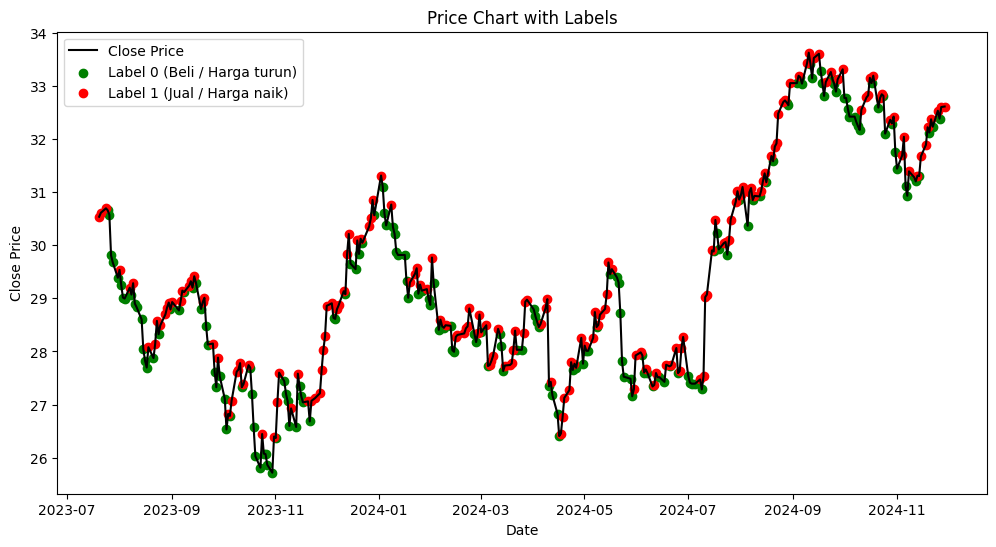

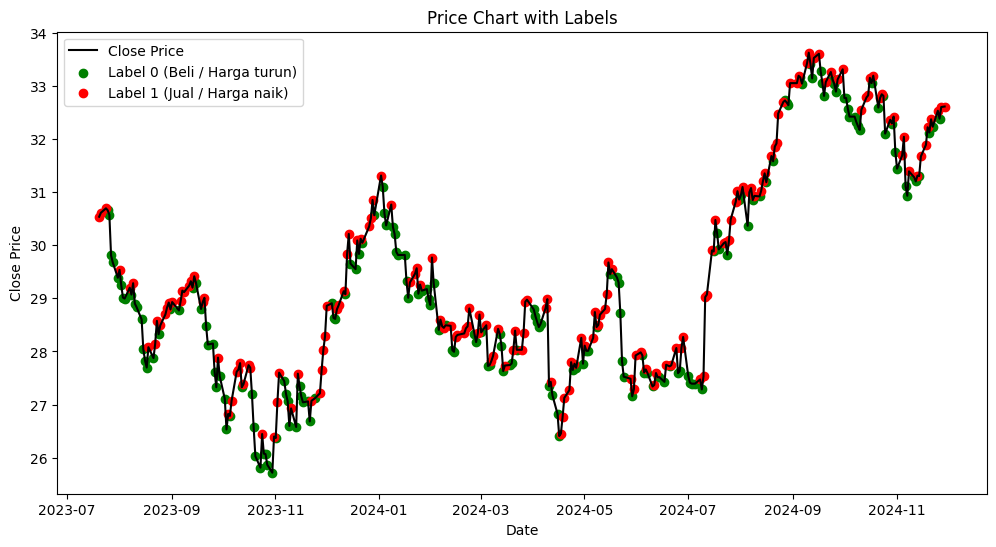

In [65]:
gambar(hasil)
gambar(hasil,'Predict_Label')

## Transform into local minima/maxima

In [66]:
for i in range(len(y_pred)-1):
    if y_pred[i] == y_pred[i+1]:
        y_pred[i] = 2 # hold

### Predict Label vs Local Maxima/Minima

                          Date       Open       High        Low      Close  \
1395 2023-07-20 04:00:00+00:00  30.143128  30.558541  29.797728  30.535202   
1396 2023-07-21 04:00:00+00:00  30.703234  30.717236  30.390508  30.609884   
1397 2023-07-24 04:00:00+00:00  30.693899  30.889936  30.488525  30.693899   
1398 2023-07-25 04:00:00+00:00  30.805925  30.819927  30.549207  30.656563   
1399 2023-07-26 04:00:00+00:00  30.591215  30.889939  30.479194  30.572544   
...                        ...        ...        ...        ...        ...   
1735 2024-11-22 05:00:00+00:00  32.500000  32.599998  32.139999  32.230000   
1736 2024-11-25 05:00:00+00:00  32.259998  32.705002  32.240002  32.529999   
1737 2024-11-26 05:00:00+00:00  32.459999  32.529999  32.320000  32.380001   
1738 2024-11-27 05:00:00+00:00  32.450001  32.875000  32.439999  32.599998   
1739 2024-11-29 05:00:00+00:00  32.540001  33.040001  32.500000  32.610001   

       Volume  Dividends  Stock Splits  label  day  ...  Moment

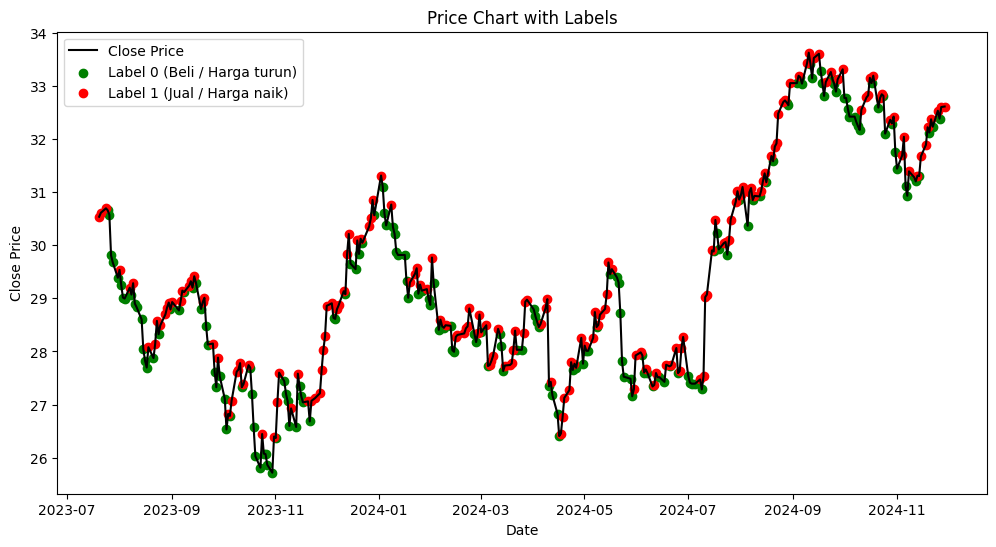

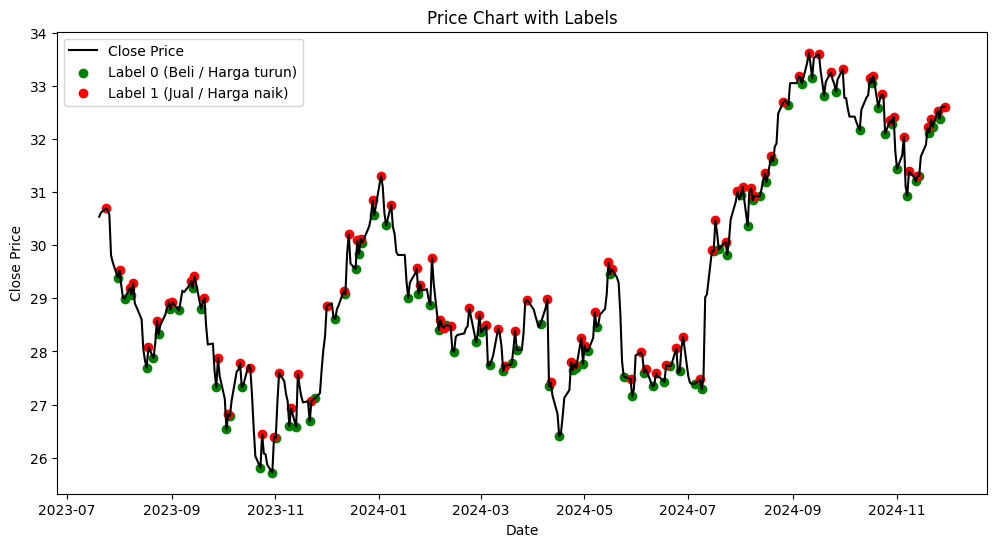

In [67]:
hasil_2 = test_set.copy()
hasil_2['Predict_Label'] = y_pred
print(hasil_2)
gambar(hasil_2)
gambar(hasil_2,'Predict_Label')

## Backtesting Algorithm

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def trading_simulation(df, initial_capital=100000):
    capital = initial_capital
    shares = 0
    transactions = []
    wealth_history = []
    fee_rate = 0.0004  # 0.04%
    
    for i in range(len(df)):
        current_price =  df['Close'].iloc[i]
        action = df['Predict_Label'].iloc[i]
        
        total_wealth = capital + (shares * current_price)
        wealth_history.append({
            'Date': df.index[i],
            'Wealth': total_wealth,
            'Cash': capital,
            'Stock Value': shares * current_price
        })
        
        if action == 0:  # Beli
            buy_amount = initial_capital * 0.3  # 30% dari modal awal
            if capital >= buy_amount:
                shares_to_buy = (buy_amount // current_price)
                cost = shares_to_buy * current_price
                fee = cost * fee_rate
                total_cost = cost + fee
                
                if total_cost <= capital:
                    capital -= total_cost
                    shares += shares_to_buy
                    transactions.append({
                        'Date': df.index[i],
                        'Action': 'Beli',
                        'Shares': shares_to_buy,
                        'Price': current_price,
                        'Cost': cost,
                        'Fee': fee,
                        'Total Cost': total_cost,
                        'Remaining Capital': capital,
                        'Total Shares': shares
                    })
                
        elif action == 1:  # Jual
            if shares > 0:
                revenue = shares * current_price
                fee = revenue * fee_rate
                net_revenue = revenue - fee
                capital += net_revenue
                transactions.append({
                    'Date': df.index[i],
                    'Action': 'Jual',
                    'Shares': shares,
                    'Price': current_price,
                    'Revenue': revenue,
                    'Fee': fee,
                    'Net Revenue': net_revenue,
                    'Remaining Capital': capital,
                    'Total Shares': 0
                })
                shares = 0
    
    final_portfolio_value = capital + (shares * df['Close'].iloc[-1])
    
    return (pd.DataFrame(transactions), 
            pd.DataFrame(wealth_history), 
            final_portfolio_value)


In [71]:
hasil_2

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,label,day,...,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI,Predict_Label
1395,2023-07-20 04:00:00+00:00,30.143128,30.558541,29.797728,30.535202,6134100,0.0,0.0,1,20,...,1.652315,98.721150,67.123487,81.052567,0.157755,0.050557,-1.278850,0.717789,196.428125,2
1396,2023-07-21 04:00:00+00:00,30.703234,30.717236,30.390508,30.609884,4616800,0.0,0.0,1,21,...,1.549633,94.292901,72.517711,80.291938,0.222422,0.084930,-5.707099,0.557143,149.470736,2
1397,2023-07-24 04:00:00+00:00,30.693899,30.889936,30.488525,30.693899,5888400,0.0,0.0,1,24,...,1.260239,89.655212,75.108960,77.777694,0.277254,0.123395,-10.344788,0.697669,117.061715,1
1398,2023-07-25 04:00:00+00:00,30.805925,30.819927,30.549207,30.656563,4918600,0.0,0.0,0,25,...,0.980192,87.684987,75.982740,73.755754,0.314076,0.161531,-12.315013,0.465529,86.861628,2
1399,2023-07-26 04:00:00+00:00,30.591215,30.889939,30.479194,30.572544,6011400,0.0,0.0,0,26,...,0.784149,83.251237,76.571022,69.266024,0.332643,0.195753,-16.748763,0.568178,61.643860,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,2024-11-22 05:00:00+00:00,32.500000,32.599998,32.139999,32.230000,3346500,0.0,0.0,0,22,...,0.840000,77.018681,61.809667,74.418592,-0.070297,-0.206302,-22.981319,0.500000,77.149873,0
1736,2024-11-25 05:00:00+00:00,32.259998,32.705002,32.240002,32.529999,6375900,0.0,0.0,1,25,...,1.249998,89.795753,68.050109,82.722433,-0.015963,-0.168234,-10.204247,1.021510,104.734024,1
1737,2024-11-26 05:00:00+00:00,32.459999,32.529999,32.320000,32.380001,3589500,0.0,0.0,0,26,...,1.180000,81.049541,73.763754,79.797994,0.014823,-0.131623,-18.950459,0.000000,68.553011,0
1738,2024-11-27 05:00:00+00:00,32.450001,32.875000,32.439999,32.599998,4634200,0.0,0.0,1,27,...,1.289999,85.411061,78.617709,80.861246,0.056324,-0.094034,-14.588939,1.137925,101.251882,2



Riwayat Transaksi:
     Date Action  Shares      Price          Cost        Fee    Total Cost  \
0    1402   Beli  1020.0  29.386982  29974.721603  11.989889  29986.711492   
1    1403   Jual  1020.0  29.536345           NaN  12.050829           NaN   
2    1406   Beli  1034.0  28.994907  29980.734230  11.992294  29992.726524   
3    1407   Jual  1034.0  29.200281           NaN  12.077236           NaN   
4    1408   Beli  1032.0  29.069588  29999.814514  11.999926  30011.814440   
..    ...    ...     ...        ...           ...        ...           ...   
165  1734   Jual   933.0  32.369999           NaN  12.080484           NaN   
166  1735   Beli   930.0  32.230000  29973.899574  11.989560  29985.889134   
167  1736   Jual   930.0  32.529999           NaN  12.101160           NaN   
168  1737   Beli   926.0  32.380001  29983.880989  11.993552  29995.874541   
169  1739   Jual   926.0  32.610001           NaN  12.078744           NaN   

     Remaining Capital  Total Shares       

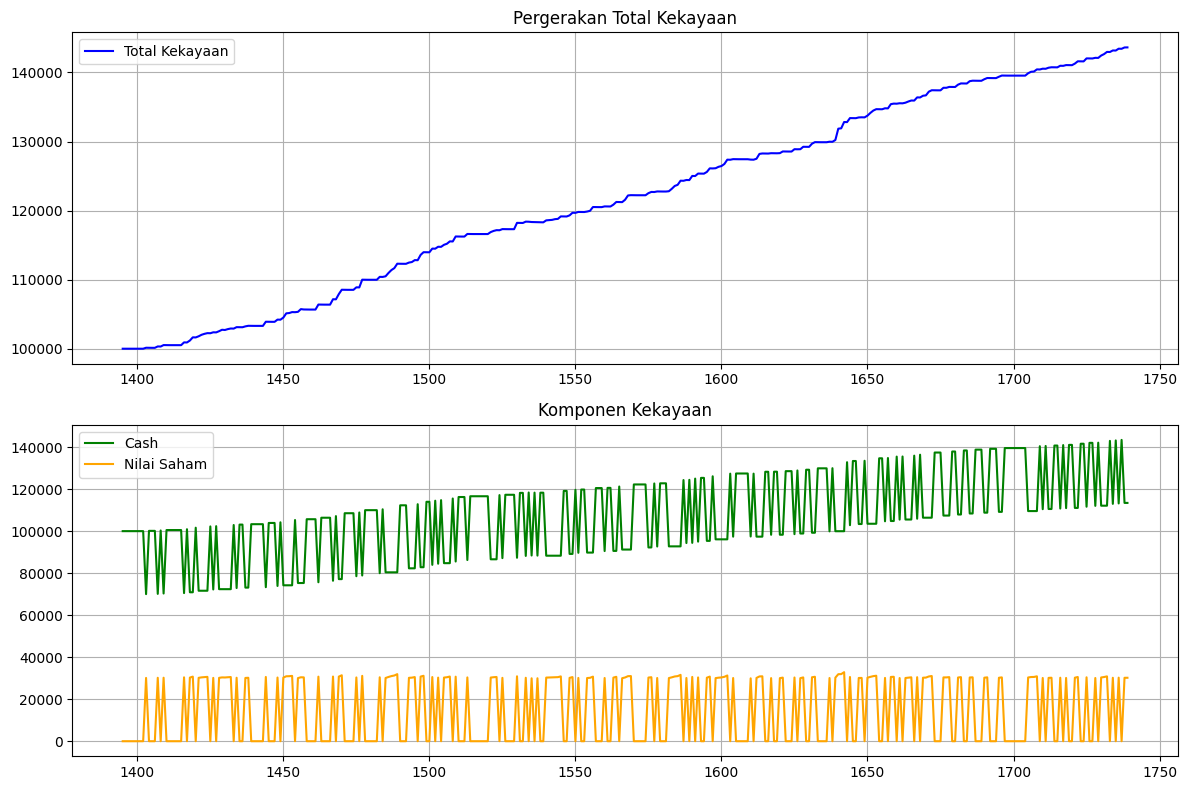


Total Return: 43.62%
Jumlah Transaksi: 170
Total Fee: USD 2,057.18


In [72]:
initial_capital = 100000
transactions, wealth_history, final_value = trading_simulation(hasil_2, initial_capital)

print("\nRiwayat Transaksi:")
print(transactions)
print(f"\nNilai Portfolio Akhir: USD {final_value:,.2f}")

plt.figure(figsize=(12, 8))


plt.subplot(2, 1, 1)
plt.plot(wealth_history['Date'], wealth_history['Wealth'], label='Total Kekayaan', color='blue')
plt.title('Pergerakan Total Kekayaan')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(wealth_history['Date'], wealth_history['Cash'], label='Cash', color='green')
plt.plot(wealth_history['Date'], wealth_history['Stock Value'], label='Nilai Saham', color='orange')
plt.title('Komponen Kekayaan')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

total_return = (final_value - initial_capital) / initial_capital * 100
print(f"\nTotal Return: {total_return:.2f}%")

total_transactions = len(transactions)
total_fees = transactions['Fee'].sum() if not transactions.empty else 0
print(f"Jumlah Transaksi: {total_transactions}")
print(f"Total Fee: USD {total_fees:,.2f}")


# 3. UHS

In [73]:
df_dict['UHS']

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,label,day,...,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
0,2018-01-02 05:00:00+00:00,110.745877,112.259221,109.960097,112.142807,754000,0.0,0.0,0,2,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
1,2018-01-03 05:00:00+00:00,111.725667,111.725667,108.951199,109.998901,845900,0.0,0.0,0,3,...,NaN,NaN,NaN,NaN,NaN,-0.171024,-0.034205,NaN,-0.150350,NaN
2,2018-01-04 05:00:00+00:00,110.736183,110.736183,108.805699,109.416855,689000,0.0,0.0,0,4,...,NaN,NaN,NaN,NaN,NaN,-0.349499,-0.097264,NaN,0.381915,NaN
3,2018-01-05 05:00:00+00:00,110.037719,110.037719,107.418470,108.621384,1201800,0.0,0.0,0,5,...,NaN,NaN,NaN,NaN,NaN,-0.548803,-0.187572,NaN,0.237039,NaN
4,2018-01-08 05:00:00+00:00,108.446780,108.456483,105.982741,106.855827,1543500,0.0,0.0,0,8,...,NaN,NaN,NaN,NaN,NaN,-0.839541,-0.317966,NaN,-0.066660,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,2024-11-22 05:00:00+00:00,195.759995,199.119995,194.990005,197.940002,1205700,0.0,0.0,1,22,...,198.963637,-9.559998,39.308756,41.883511,18.839697,-5.830037,-5.585553,-60.691244,0.365617,-58.611513
1736,2024-11-25 05:00:00+00:00,196.720001,200.259995,195.350006,199.210007,713800,0.0,0.0,1,25,...,198.691820,-9.349991,48.731988,38.720801,19.935786,-5.573442,-5.583131,-51.268012,0.472505,-16.077939
1737,2024-11-26 05:00:00+00:00,199.589996,206.710007,198.119995,206.089996,986700,0.0,0.0,1,26,...,199.840910,0.849991,94.826584,41.973857,52.223939,-4.760061,-5.418517,-5.173416,0.873107,171.479651
1738,2024-11-27 05:00:00+00:00,206.009995,208.440002,202.059998,203.500000,566600,0.0,0.0,0,27,...,200.503637,0.750000,74.040973,44.503088,51.952106,-4.275159,-5.189845,-25.959027,0.368339,94.669901


In [74]:
X_train = df_dict['UHS'].dropna(subset=features)
split_fraction = 0.8
split_index = int(len(X_train) * split_fraction)
train_set = X_train.iloc[:split_index]
test_set = X_train.iloc[split_index:]

In [75]:
test_set

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,label,day,...,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
1395,2023-07-20 04:00:00+00:00,152.717190,152.786772,149.645953,150.500732,507800,0.0,0.0,0,20,...,151.865852,-0.506912,28.588264,37.021364,47.335383,2.274187,3.124560,-71.411736,0.420882,-122.078626
1396,2023-07-21 04:00:00+00:00,150.858535,151.454899,147.220751,147.608383,669500,0.0,0.0,0,21,...,151.085163,-2.435150,4.184532,34.694354,39.357005,1.779240,2.855496,-95.815468,0.225350,-249.924205
1397,2023-07-24 04:00:00+00:00,148.463200,149.278229,147.002123,147.419586,522000,0.0,0.0,0,24,...,150.314422,-5.297623,4.402663,30.757481,20.421780,1.356124,2.555621,-95.597337,0.733641,-157.347723
1398,2023-07-25 04:00:00+00:00,146.544896,149.377585,145.531084,148.731537,852600,0.0,0.0,1,25,...,149.878538,-3.041428,29.219584,30.768825,33.688549,1.113825,2.267262,-70.780416,0.509034,-77.193968
1399,2023-07-26 04:00:00+00:00,142.986621,145.411810,137.659161,140.571365,1922300,0.0,0.0,0,26,...,148.014285,-12.444000,15.469852,27.895547,11.688968,0.260343,1.865878,-84.530148,-0.428206,-214.644631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,2024-11-22 05:00:00+00:00,195.759995,199.119995,194.990005,197.940002,1205700,0.0,0.0,1,22,...,198.963637,-9.559998,39.308756,41.883511,18.839697,-5.830037,-5.585553,-60.691244,0.365617,-58.611513
1736,2024-11-25 05:00:00+00:00,196.720001,200.259995,195.350006,199.210007,713800,0.0,0.0,1,25,...,198.691820,-9.349991,48.731988,38.720801,19.935786,-5.573442,-5.583131,-51.268012,0.472505,-16.077939
1737,2024-11-26 05:00:00+00:00,199.589996,206.710007,198.119995,206.089996,986700,0.0,0.0,1,26,...,199.840910,0.849991,94.826584,41.973857,52.223939,-4.760061,-5.418517,-5.173416,0.873107,171.479651
1738,2024-11-27 05:00:00+00:00,206.009995,208.440002,202.059998,203.500000,566600,0.0,0.0,0,27,...,200.503637,0.750000,74.040973,44.503088,51.952106,-4.275159,-5.189845,-25.959027,0.368339,94.669901


In [76]:
ChoosenFeature = ['A/D_Oscillator', 'Stochastic_K', 'day', 'Momentum', 'Williams_R', 'High', 'Close', 'Low', 'Open','WMA']

In [77]:
y_train_UHS = train_set['label']  
X_train_UHS = train_set.drop(columns=['label','Date','Dividends','Stock Splits'])
X_train_UHS  = X_train_UHS[ChoosenFeature]

In [78]:
y_test_UHS = test_set['label']  
X_test_UHS = test_set.drop(columns=['label','Date','Dividends','Stock Splits'])
X_test_UHS  = X_test_UHS[ChoosenFeature]

In [79]:
X_train_UHS

,A/D_Oscillator,Stochastic_K,day,Momentum,Williams_R,High,Close,Low,Open,WMA
18,0.372884,75.602355,29,3.511726,-24.397645,118.244703,116.673149,116.527641,117.682047,115.319963
19,0.684796,67.811567,30,5.927269,-32.188433,122.047468,118.865562,114.199415,116.129899,116.091451
20,0.065442,57.703739,31,5.287018,-42.296261,119.176004,117.866379,114.432246,119.030488,116.573501
21,0.321314,54.754509,1,3.851257,-45.245491,118.904354,117.662636,115.673941,117.371605,116.922379
22,0.000001,34.834577,2,1.173813,-65.165423,117.662639,115.732155,114.810562,116.818655,116.850238
...,...,...,...,...,...,...,...,...,...,...
1390,0.192513,33.816122,13,-2.663742,-66.183878,153.373178,152.160583,151.514536,152.925913,152.376370
1391,0.757842,40.941817,14,-2.812836,-59.058183,156.484192,152.747009,150.779034,152.667508,152.325407
1392,0.083341,44.056001,17,-4.303711,-55.943999,152.945815,152.508484,150.560376,151.932003,152.282218
1393,0.479545,38.181659,18,-2.375504,-61.818341,153.790629,152.091019,151.116957,151.554289,152.241375


In [80]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(C=10, penalty='l1', solver='liblinear'))
])

pipeline.fit(X_train_UHS, y_train_UHS)


y_pred = pipeline.predict(X_test_UHS)

accuracy = accuracy_score(y_test_UHS, y_pred)
precision = precision_score(y_test_UHS, y_pred)
recall = recall_score(y_test_UHS, y_pred)
f1 = f1_score(y_test_UHS, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.9594202898550724
Precision: 0.9393939393939394
Recall: 0.9893617021276596
F1 Score: 0.9637305699481865


## Menggunakan data test sebagai backtest

In [81]:
hasil = test_set.copy()
hasil['Predict_Label'] = y_pred
print(hasil)

                          Date        Open        High         Low  \
1395 2023-07-20 04:00:00+00:00  152.717190  152.786772  149.645953   
1396 2023-07-21 04:00:00+00:00  150.858535  151.454899  147.220751   
1397 2023-07-24 04:00:00+00:00  148.463200  149.278229  147.002123   
1398 2023-07-25 04:00:00+00:00  146.544896  149.377585  145.531084   
1399 2023-07-26 04:00:00+00:00  142.986621  145.411810  137.659161   
...                        ...         ...         ...         ...   
1735 2024-11-22 05:00:00+00:00  195.759995  199.119995  194.990005   
1736 2024-11-25 05:00:00+00:00  196.720001  200.259995  195.350006   
1737 2024-11-26 05:00:00+00:00  199.589996  206.710007  198.119995   
1738 2024-11-27 05:00:00+00:00  206.009995  208.440002  202.059998   
1739 2024-11-29 05:00:00+00:00  202.479996  205.250000  201.960007   

           Close   Volume  Dividends  Stock Splits  label  day  ...  \
1395  150.500732   507800        0.0           0.0      0   20  ...   
1396  147.608383 

### Label asli VS Prediction

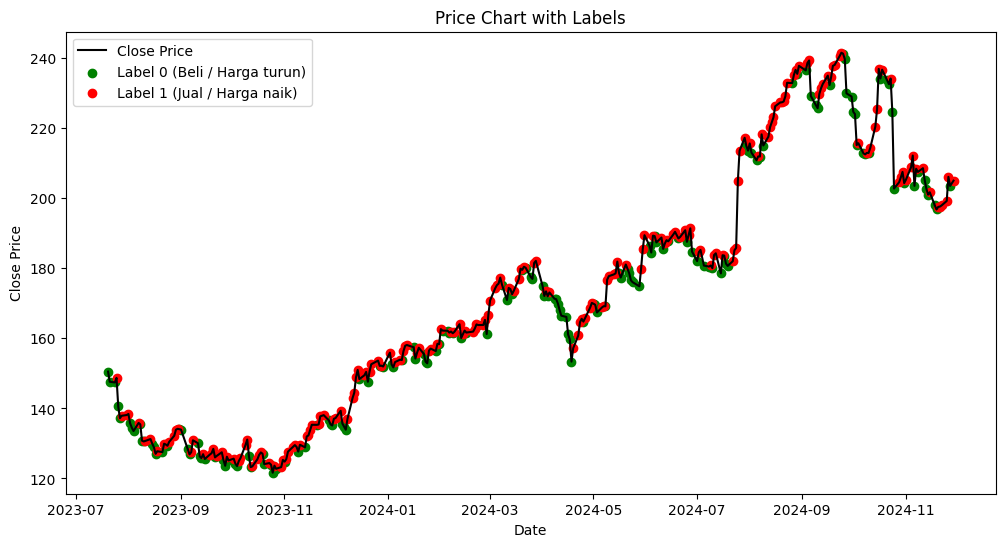

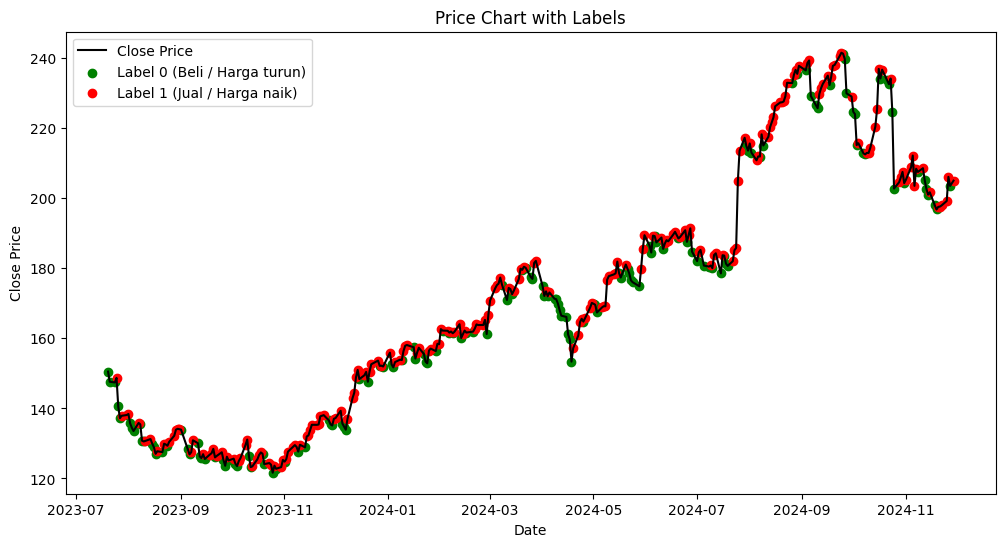

In [82]:
gambar(hasil)
gambar(hasil,'Predict_Label')

## Transform into local minima/maxima

In [83]:
for i in range(len(y_pred)-1):
    if y_pred[i] == y_pred[i+1]:
        y_pred[i] = 2 # hold

### Predict Label vs Local Maxima/Minima

                          Date        Open        High         Low  \
1395 2023-07-20 04:00:00+00:00  152.717190  152.786772  149.645953   
1396 2023-07-21 04:00:00+00:00  150.858535  151.454899  147.220751   
1397 2023-07-24 04:00:00+00:00  148.463200  149.278229  147.002123   
1398 2023-07-25 04:00:00+00:00  146.544896  149.377585  145.531084   
1399 2023-07-26 04:00:00+00:00  142.986621  145.411810  137.659161   
...                        ...         ...         ...         ...   
1735 2024-11-22 05:00:00+00:00  195.759995  199.119995  194.990005   
1736 2024-11-25 05:00:00+00:00  196.720001  200.259995  195.350006   
1737 2024-11-26 05:00:00+00:00  199.589996  206.710007  198.119995   
1738 2024-11-27 05:00:00+00:00  206.009995  208.440002  202.059998   
1739 2024-11-29 05:00:00+00:00  202.479996  205.250000  201.960007   

           Close   Volume  Dividends  Stock Splits  label  day  ...  \
1395  150.500732   507800        0.0           0.0      0   20  ...   
1396  147.608383 

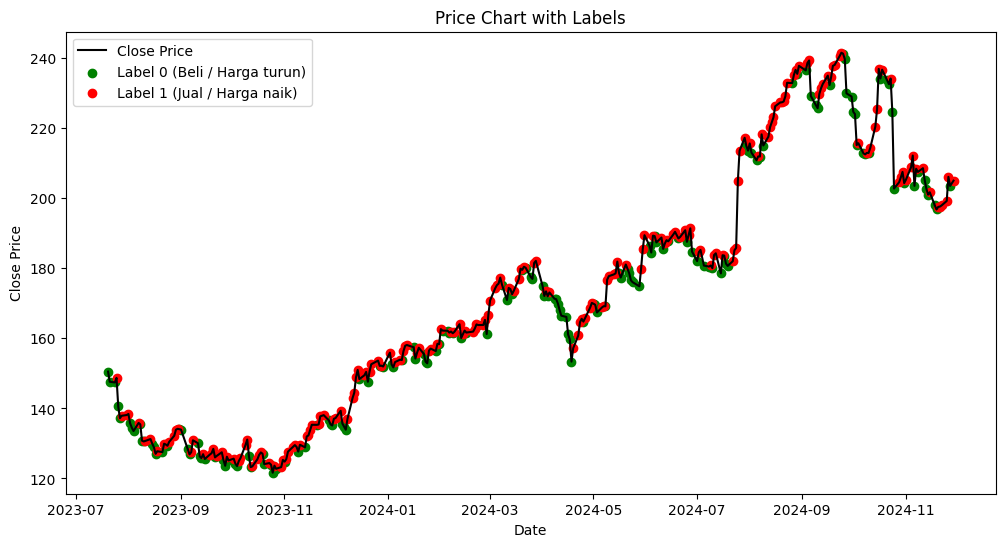

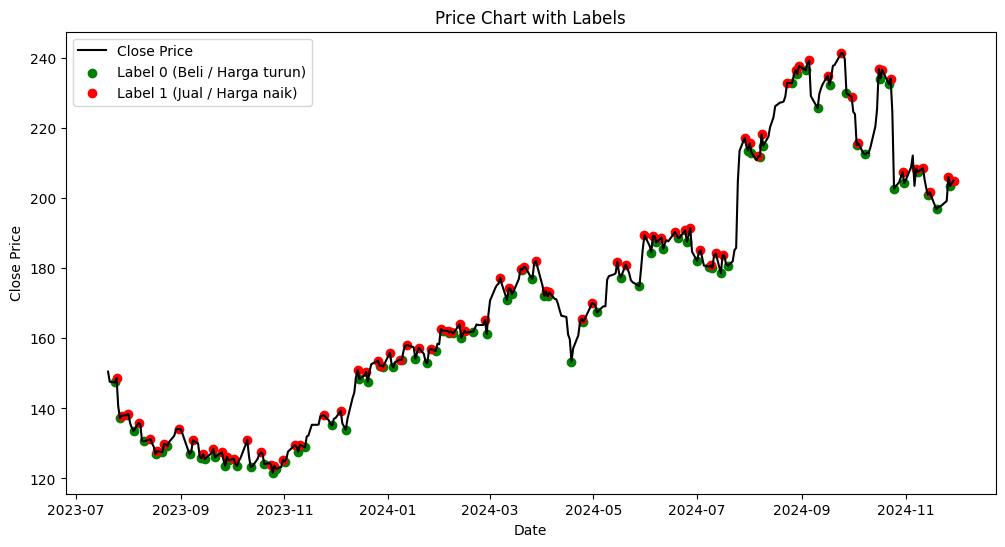

In [84]:
hasil_2 = test_set.copy()
hasil_2['Predict_Label'] = y_pred
print(hasil_2)
gambar(hasil_2)
gambar(hasil_2,'Predict_Label')

## Backtesting Algorithm

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def trading_simulation(df, initial_capital=100000):
    capital = initial_capital
    shares = 0
    transactions = []
    wealth_history = []
    fee_rate = 0.0004  # 0.04%
    
    for i in range(len(df)):
        current_price =  df['Close'].iloc[i]
        action = df['Predict_Label'].iloc[i]
        
        total_wealth = capital + (shares * current_price)
        wealth_history.append({
            'Date': df.index[i],
            'Wealth': total_wealth,
            'Cash': capital,
            'Stock Value': shares * current_price
        })
        
        if action == 0:  # Beli
            buy_amount = initial_capital * 0.3  # 30% dari modal awal
            if capital >= buy_amount:
                shares_to_buy = (buy_amount // current_price)
                cost = shares_to_buy * current_price
                fee = cost * fee_rate
                total_cost = cost + fee
                
                if total_cost <= capital:
                    capital -= total_cost
                    shares += shares_to_buy
                    transactions.append({
                        'Date': df.index[i],
                        'Action': 'Beli',
                        'Shares': shares_to_buy,
                        'Price': current_price,
                        'Cost': cost,
                        'Fee': fee,
                        'Total Cost': total_cost,
                        'Remaining Capital': capital,
                        'Total Shares': shares
                    })
                
        elif action == 1:  # Jual
            if shares > 0:
                revenue = shares * current_price
                fee = revenue * fee_rate
                net_revenue = revenue - fee
                capital += net_revenue
                transactions.append({
                    'Date': df.index[i],
                    'Action': 'Jual',
                    'Shares': shares,
                    'Price': current_price,
                    'Revenue': revenue,
                    'Fee': fee,
                    'Net Revenue': net_revenue,
                    'Remaining Capital': capital,
                    'Total Shares': 0
                })
                shares = 0
    
    final_portfolio_value = capital + (shares * df['Close'].iloc[-1])
    
    return (pd.DataFrame(transactions), 
            pd.DataFrame(wealth_history), 
            final_portfolio_value)


In [86]:
hasil_2

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,label,day,...,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI,Predict_Label
1395,2023-07-20 04:00:00+00:00,152.717190,152.786772,149.645953,150.500732,507800,0.0,0.0,0,20,...,-0.506912,28.588264,37.021364,47.335383,2.274187,3.124560,-71.411736,0.420882,-122.078626,2
1396,2023-07-21 04:00:00+00:00,150.858535,151.454899,147.220751,147.608383,669500,0.0,0.0,0,21,...,-2.435150,4.184532,34.694354,39.357005,1.779240,2.855496,-95.815468,0.225350,-249.924205,2
1397,2023-07-24 04:00:00+00:00,148.463200,149.278229,147.002123,147.419586,522000,0.0,0.0,0,24,...,-5.297623,4.402663,30.757481,20.421780,1.356124,2.555621,-95.597337,0.733641,-157.347723,0
1398,2023-07-25 04:00:00+00:00,146.544896,149.377585,145.531084,148.731537,852600,0.0,0.0,1,25,...,-3.041428,29.219584,30.768825,33.688549,1.113825,2.267262,-70.780416,0.509034,-77.193968,1
1399,2023-07-26 04:00:00+00:00,142.986621,145.411810,137.659161,140.571365,1922300,0.0,0.0,0,26,...,-12.444000,15.469852,27.895547,11.688968,0.260343,1.865878,-84.530148,-0.428206,-214.644631,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,2024-11-22 05:00:00+00:00,195.759995,199.119995,194.990005,197.940002,1205700,0.0,0.0,1,22,...,-9.559998,39.308756,41.883511,18.839697,-5.830037,-5.585553,-60.691244,0.365617,-58.611513,2
1736,2024-11-25 05:00:00+00:00,196.720001,200.259995,195.350006,199.210007,713800,0.0,0.0,1,25,...,-9.349991,48.731988,38.720801,19.935786,-5.573442,-5.583131,-51.268012,0.472505,-16.077939,2
1737,2024-11-26 05:00:00+00:00,199.589996,206.710007,198.119995,206.089996,986700,0.0,0.0,1,26,...,0.849991,94.826584,41.973857,52.223939,-4.760061,-5.418517,-5.173416,0.873107,171.479651,1
1738,2024-11-27 05:00:00+00:00,206.009995,208.440002,202.059998,203.500000,566600,0.0,0.0,0,27,...,0.750000,74.040973,44.503088,51.952106,-4.275159,-5.189845,-25.959027,0.368339,94.669901,0



Riwayat Transaksi:
     Date Action  Shares       Price          Cost        Fee    Total Cost  \
0    1397   Beli   203.0  147.419586  29926.175995  11.970470  29938.146465   
1    1398   Jual   203.0  148.731537           NaN  12.077001           NaN   
2    1400   Beli   218.0  137.211899  29912.193939  11.964878  29924.158817   
3    1401   Jual   218.0  137.897720           NaN  12.024681           NaN   
4    1402   Beli   217.0  138.116379  29971.254196  11.988502  29983.242698   
..    ...    ...     ...         ...           ...        ...           ...   
155  1730   Jual   149.0  201.690002           NaN  12.020724           NaN   
156  1732   Beli   152.0  196.789993  29912.078979  11.964832  29924.043811   
157  1737   Jual   152.0  206.089996           NaN  12.530272           NaN   
158  1738   Beli   147.0  203.500000  29914.500000  11.965800  29926.465800   
159  1739   Jual   147.0  205.000000           NaN  12.054000           NaN   

     Remaining Capital  Total S

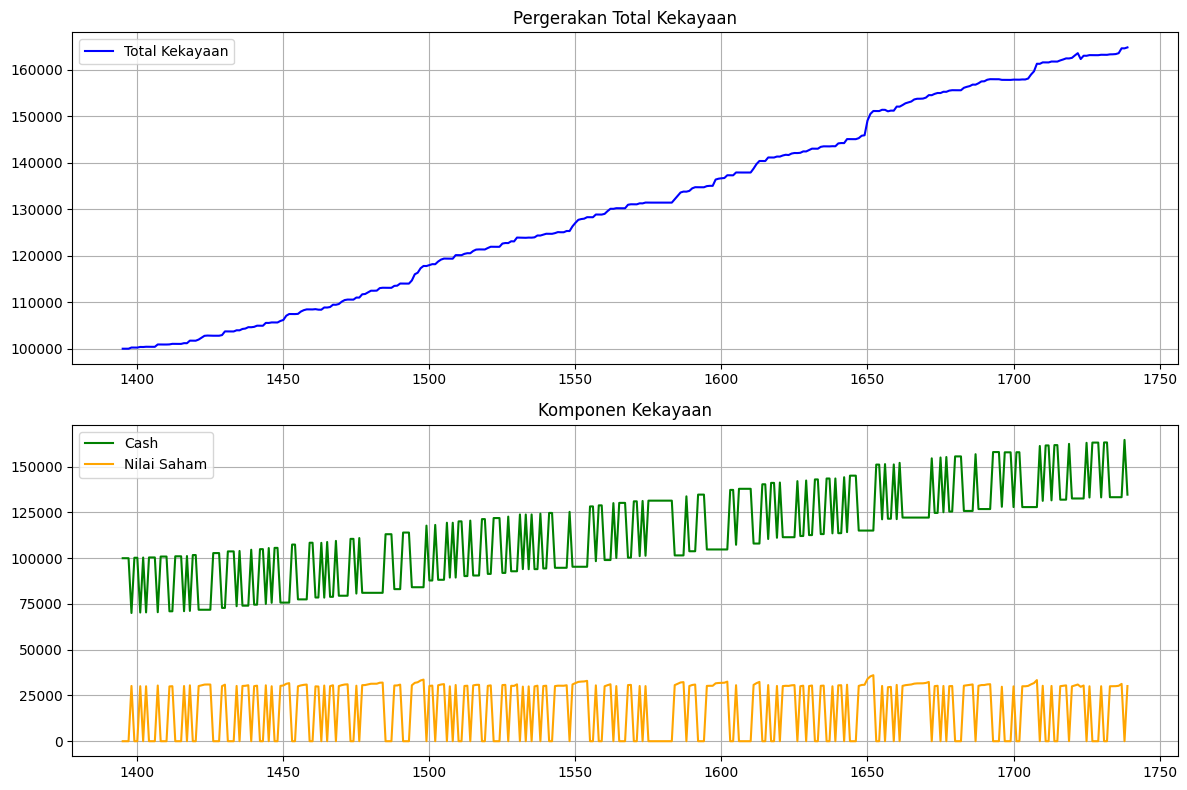


Total Return: 64.84%
Jumlah Transaksi: 160
Total Fee: USD 1,941.53


In [87]:
initial_capital = 100000
transactions, wealth_history, final_value = trading_simulation(hasil_2, initial_capital)

print("\nRiwayat Transaksi:")
print(transactions)
print(f"\nNilai Portfolio Akhir: USD {final_value:,.2f}")

plt.figure(figsize=(12, 8))


plt.subplot(2, 1, 1)
plt.plot(wealth_history['Date'], wealth_history['Wealth'], label='Total Kekayaan', color='blue')
plt.title('Pergerakan Total Kekayaan')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(wealth_history['Date'], wealth_history['Cash'], label='Cash', color='green')
plt.plot(wealth_history['Date'], wealth_history['Stock Value'], label='Nilai Saham', color='orange')
plt.title('Komponen Kekayaan')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

total_return = (final_value - initial_capital) / initial_capital * 100
print(f"\nTotal Return: {total_return:.2f}%")

total_transactions = len(transactions)
total_fees = transactions['Fee'].sum() if not transactions.empty else 0
print(f"Jumlah Transaksi: {total_transactions}")
print(f"Total Fee: USD {total_fees:,.2f}")


# 4. BWA

In [88]:
df_dict['BWA']

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,label,day,...,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
0,2018-01-02 05:00:00+00:00,40.645727,40.993800,40.416312,40.962158,1348318,0.0,0.0,0,2,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
1,2018-01-03 05:00:00+00:00,41.033342,41.231115,40.843484,41.167828,1343093,0.0,0.0,1,3,...,NaN,NaN,NaN,NaN,NaN,0.016407,0.003281,NaN,0.693847,NaN
2,2018-01-04 05:00:00+00:00,41.444706,42.749989,41.413061,42.504753,1924611,0.0,0.0,1,4,...,NaN,NaN,NaN,NaN,NaN,0.135723,0.029770,NaN,1.183430,NaN
3,2018-01-05 05:00:00+00:00,42.797464,43.794228,42.750002,43.738853,2501586,0.0,0.0,1,5,...,NaN,NaN,NaN,NaN,NaN,0.326105,0.089037,NaN,1.234861,NaN
4,2018-01-08 05:00:00+00:00,43.825856,44.094825,43.517337,43.762569,2122843,0.0,0.0,1,8,...,NaN,NaN,NaN,NaN,NaN,0.473440,0.165917,NaN,0.616414,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,2024-11-22 05:00:00+00:00,33.619999,34.250000,33.619999,34.119999,1681100,0.0,0.0,1,22,...,33.987273,0.200001,42.905379,46.841017,52.293588,-0.118963,-0.051750,-57.094621,0.777779,-13.457712
1736,2024-11-25 05:00:00+00:00,34.459999,35.520000,34.459999,35.180000,2370600,0.0,0.0,1,25,...,34.161091,0.520000,78.716201,47.970698,55.555565,-0.020883,-0.045577,-21.283799,1.320754,108.237514
1737,2024-11-26 05:00:00+00:00,34.650002,34.849998,33.900002,34.169998,2298700,0.0,0.0,0,26,...,34.141818,-0.970001,44.594541,44.139826,40.690966,-0.024372,-0.041336,-55.405459,-0.347371,-1.247666
1738,2024-11-27 05:00:00+00:00,34.290001,34.750000,34.189999,34.279999,1220700,0.0,0.0,1,27,...,34.160181,-0.530003,53.558024,42.582046,44.689355,-0.018053,-0.036679,-46.441976,1.035715,23.504117


In [89]:
X_train = df_dict['BWA'].dropna(subset=features)
split_fraction = 0.8
split_index = int(len(X_train) * split_fraction)
train_set = X_train.iloc[:split_index]
test_set = X_train.iloc[split_index:]

In [90]:
test_set

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,label,day,...,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
1395,2023-07-20 04:00:00+00:00,45.129648,45.474151,44.873734,45.415092,1550200,0.0,0.0,1,20,...,45.154163,1.230366,61.276882,79.417453,63.498979,1.273288,1.166628,-38.723118,0.442629,54.105937
1396,2023-07-21 04:00:00+00:00,46.054882,46.064723,45.169020,45.415092,1869500,0.0,0.0,0,21,...,45.225391,1.171310,61.276882,76.468965,63.019770,1.252170,1.183736,-38.723118,0.725275,41.242086
1397,2023-07-24 04:00:00+00:00,45.385562,45.671007,45.237917,45.424934,1727600,0.0,0.0,1,24,...,45.277111,1.318951,60.869820,73.794823,65.090129,1.222139,1.191417,-39.130180,0.590904,28.624493
1398,2023-07-25 04:00:00+00:00,45.228073,45.562731,45.100114,45.277287,1317600,0.0,0.0,0,25,...,45.278005,0.423244,44.736863,68.693927,55.613571,1.172906,1.187715,-55.263137,0.297864,-7.966941
1399,2023-07-26 04:00:00+00:00,45.050902,45.789119,45.050902,45.671005,1083100,0.0,0.0,1,26,...,45.342790,0.000000,65.789699,65.510288,50.000000,1.152374,1.180646,-34.210301,0.693336,75.890853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,2024-11-22 05:00:00+00:00,33.619999,34.250000,33.619999,34.119999,1681100,0.0,0.0,1,22,...,33.987273,0.200001,42.905379,46.841017,52.293588,-0.118963,-0.051750,-57.094621,0.777779,-13.457712
1736,2024-11-25 05:00:00+00:00,34.459999,35.520000,34.459999,35.180000,2370600,0.0,0.0,1,25,...,34.161091,0.520000,78.716201,47.970698,55.555565,-0.020883,-0.045577,-21.283799,1.320754,108.237514
1737,2024-11-26 05:00:00+00:00,34.650002,34.849998,33.900002,34.169998,2298700,0.0,0.0,0,26,...,34.141818,-0.970001,44.594541,44.139826,40.690966,-0.024372,-0.041336,-55.405459,-0.347371,-1.247666
1738,2024-11-27 05:00:00+00:00,34.290001,34.750000,34.189999,34.279999,1220700,0.0,0.0,1,27,...,34.160181,-0.530003,53.558024,42.582046,44.689355,-0.018053,-0.036679,-46.441976,1.035715,23.504117


In [91]:
ChoosenFeature = ['A/D_Oscillator', 'Stochastic_K', 'Stochastic_D', 'Volume', 'year', 'month', 'Williams_R', 'SMA', 'Open', 'Close', 'High', 'Low', 'day_of_week', 'WMA']

In [95]:
y_train_BWA = train_set['label']  
X_train_BWA = train_set.drop(columns=['label','Date','Dividends','Stock Splits'])
X_train_BWA  = X_train_BWA[ChoosenFeature]

In [96]:
y_test_BWA = test_set['label']  
X_test_BWA = test_set.drop(columns=['label','Date','Dividends','Stock Splits'])
X_test_BWA  = X_test_BWA[ChoosenFeature]

In [97]:
X_train_BWA

,A/D_Oscillator,Stochastic_K,Stochastic_D,Volume,year,month,Williams_R,SMA,Open,Close,High,Low,day_of_week,WMA
18,0.619557,46.565005,64.452952,1188142,2018,1,-53.434995,44.921514,45.059953,44.949200,45.669083,44.941291,0,44.878580
19,0.430239,42.748352,61.036593,1068067,2018,1,-57.251648,44.953157,44.759345,44.870094,45.241904,44.561575,1,44.869231
20,0.503645,25.781280,54.085131,1254371,2018,1,-74.218720,44.822628,45.162791,44.506191,45.415935,44.332155,2,44.787964
21,0.255316,46.825191,50.658614,1152586,2018,2,-53.174809,44.765669,44.086915,44.609028,44.790977,43.675554,3,44.749128
22,-0.074861,2.686637,43.989489,1402619,2018,2,-97.313363,44.570272,44.229316,43.090160,44.498285,43.018961,4,44.444490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390,0.773803,98.051085,91.525580,2735800,2023,7,-1.948915,43.915919,45.867857,46.212360,46.310788,45.483985,3,44.607271
1391,-0.069767,68.991342,89.750006,2615400,2023,7,-31.008658,44.230814,46.025344,44.903255,46.123775,44.854042,4,44.786787
1392,0.020837,59.679998,86.447623,1934600,2023,7,-40.320002,44.461671,44.637497,44.686714,44.913100,44.440642,0,44.869678
1393,0.860465,64.376737,83.105486,1740700,2023,7,-35.623263,44.629625,44.765458,44.932789,45.415088,44.568599,1,44.955335


In [99]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(C=10, penalty='l1', solver='liblinear'))
])

pipeline.fit(X_train_BWA, y_train_BWA)


y_pred = pipeline.predict(X_test_BWA)

accuracy = accuracy_score(y_test_BWA, y_pred)
precision = precision_score(y_test_BWA, y_pred)
recall = recall_score(y_test_BWA, y_pred)
f1 = f1_score(y_test_BWA, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.9623188405797102
Precision: 0.9710982658959537
Recall: 0.9545454545454546
F1 Score: 0.9627507163323782


## Menggunakan data test sebagai backtest

In [100]:
hasil = test_set.copy()
hasil['Predict_Label'] = y_pred
print(hasil)

                          Date       Open       High        Low      Close  \
1395 2023-07-20 04:00:00+00:00  45.129648  45.474151  44.873734  45.415092   
1396 2023-07-21 04:00:00+00:00  46.054882  46.064723  45.169020  45.415092   
1397 2023-07-24 04:00:00+00:00  45.385562  45.671007  45.237917  45.424934   
1398 2023-07-25 04:00:00+00:00  45.228073  45.562731  45.100114  45.277287   
1399 2023-07-26 04:00:00+00:00  45.050902  45.789119  45.050902  45.671005   
...                        ...        ...        ...        ...        ...   
1735 2024-11-22 05:00:00+00:00  33.619999  34.250000  33.619999  34.119999   
1736 2024-11-25 05:00:00+00:00  34.459999  35.520000  34.459999  35.180000   
1737 2024-11-26 05:00:00+00:00  34.650002  34.849998  33.900002  34.169998   
1738 2024-11-27 05:00:00+00:00  34.290001  34.750000  34.189999  34.279999   
1739 2024-11-29 05:00:00+00:00  34.439999  34.680000  33.919998  34.320000   

       Volume  Dividends  Stock Splits  label  day  ...  Moment

### Label asli VS Prediction

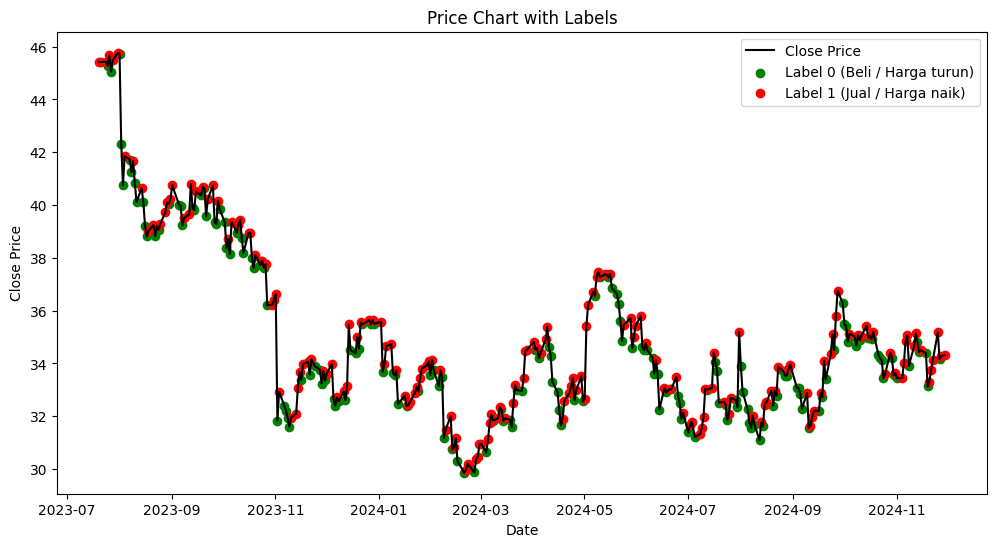

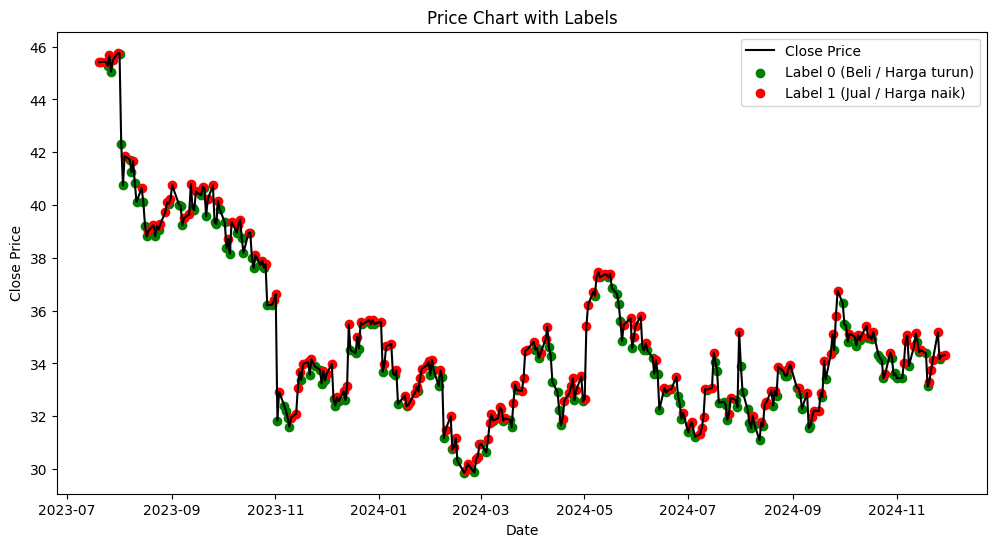

In [101]:
gambar(hasil)
gambar(hasil,'Predict_Label')

## Transform into local minima/maxima

In [102]:
for i in range(len(y_pred)-1):
    if y_pred[i] == y_pred[i+1]:
        y_pred[i] = 2 # hold

### Predict Label vs Local Maxima/Minima

                          Date       Open       High        Low      Close  \
1395 2023-07-20 04:00:00+00:00  45.129648  45.474151  44.873734  45.415092   
1396 2023-07-21 04:00:00+00:00  46.054882  46.064723  45.169020  45.415092   
1397 2023-07-24 04:00:00+00:00  45.385562  45.671007  45.237917  45.424934   
1398 2023-07-25 04:00:00+00:00  45.228073  45.562731  45.100114  45.277287   
1399 2023-07-26 04:00:00+00:00  45.050902  45.789119  45.050902  45.671005   
...                        ...        ...        ...        ...        ...   
1735 2024-11-22 05:00:00+00:00  33.619999  34.250000  33.619999  34.119999   
1736 2024-11-25 05:00:00+00:00  34.459999  35.520000  34.459999  35.180000   
1737 2024-11-26 05:00:00+00:00  34.650002  34.849998  33.900002  34.169998   
1738 2024-11-27 05:00:00+00:00  34.290001  34.750000  34.189999  34.279999   
1739 2024-11-29 05:00:00+00:00  34.439999  34.680000  33.919998  34.320000   

       Volume  Dividends  Stock Splits  label  day  ...  Moment

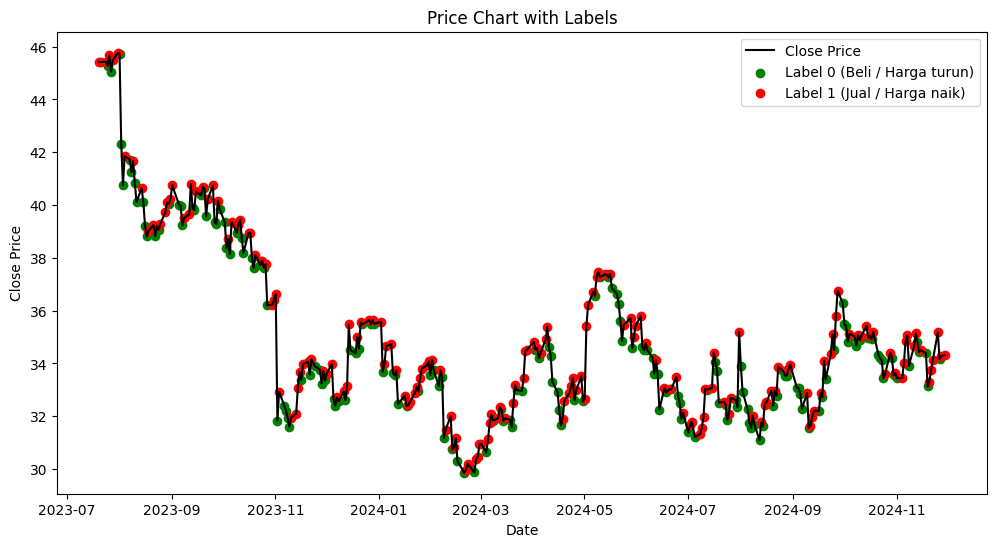

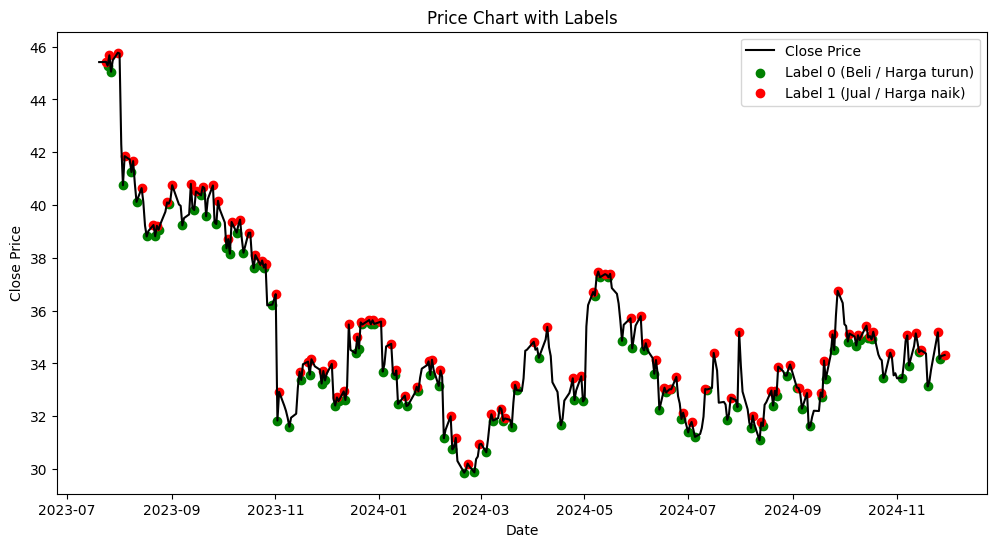

In [103]:
hasil_2 = test_set.copy()
hasil_2['Predict_Label'] = y_pred
print(hasil_2)
gambar(hasil_2)
gambar(hasil_2,'Predict_Label')

## Backtesting Algorithm

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def trading_simulation(df, initial_capital=100000):
    capital = initial_capital
    shares = 0
    transactions = []
    wealth_history = []
    fee_rate = 0.0004  # 0.04%
    
    for i in range(len(df)):
        current_price =  df['Close'].iloc[i]
        action = df['Predict_Label'].iloc[i]
        
        total_wealth = capital + (shares * current_price)
        wealth_history.append({
            'Date': df.index[i],
            'Wealth': total_wealth,
            'Cash': capital,
            'Stock Value': shares * current_price
        })
        
        if action == 0:  # Beli
            buy_amount = initial_capital * 0.3  # 30% dari modal awal
            if capital >= buy_amount:
                shares_to_buy = (buy_amount // current_price)
                cost = shares_to_buy * current_price
                fee = cost * fee_rate
                total_cost = cost + fee
                
                if total_cost <= capital:
                    capital -= total_cost
                    shares += shares_to_buy
                    transactions.append({
                        'Date': df.index[i],
                        'Action': 'Beli',
                        'Shares': shares_to_buy,
                        'Price': current_price,
                        'Cost': cost,
                        'Fee': fee,
                        'Total Cost': total_cost,
                        'Remaining Capital': capital,
                        'Total Shares': shares
                    })
                
        elif action == 1:  # Jual
            if shares > 0:
                revenue = shares * current_price
                fee = revenue * fee_rate
                net_revenue = revenue - fee
                capital += net_revenue
                transactions.append({
                    'Date': df.index[i],
                    'Action': 'Jual',
                    'Shares': shares,
                    'Price': current_price,
                    'Revenue': revenue,
                    'Fee': fee,
                    'Net Revenue': net_revenue,
                    'Remaining Capital': capital,
                    'Total Shares': 0
                })
                shares = 0
    
    final_portfolio_value = capital + (shares * df['Close'].iloc[-1])
    
    return (pd.DataFrame(transactions), 
            pd.DataFrame(wealth_history), 
            final_portfolio_value)


In [105]:
hasil_2

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,label,day,...,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI,Predict_Label
1395,2023-07-20 04:00:00+00:00,45.129648,45.474151,44.873734,45.415092,1550200,0.0,0.0,1,20,...,1.230366,61.276882,79.417453,63.498979,1.273288,1.166628,-38.723118,0.442629,54.105937,2
1396,2023-07-21 04:00:00+00:00,46.054882,46.064723,45.169020,45.415092,1869500,0.0,0.0,0,21,...,1.171310,61.276882,76.468965,63.019770,1.252170,1.183736,-38.723118,0.725275,41.242086,2
1397,2023-07-24 04:00:00+00:00,45.385562,45.671007,45.237917,45.424934,1727600,0.0,0.0,1,24,...,1.318951,60.869820,73.794823,65.090129,1.222139,1.191417,-39.130180,0.590904,28.624493,1
1398,2023-07-25 04:00:00+00:00,45.228073,45.562731,45.100114,45.277287,1317600,0.0,0.0,0,25,...,0.423244,44.736863,68.693927,55.613571,1.172906,1.187715,-55.263137,0.297864,-7.966941,0
1399,2023-07-26 04:00:00+00:00,45.050902,45.789119,45.050902,45.671005,1083100,0.0,0.0,1,26,...,0.000000,65.789699,65.510288,50.000000,1.152374,1.180646,-34.210301,0.693336,75.890853,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,2024-11-22 05:00:00+00:00,33.619999,34.250000,33.619999,34.119999,1681100,0.0,0.0,1,22,...,0.200001,42.905379,46.841017,52.293588,-0.118963,-0.051750,-57.094621,0.777779,-13.457712,2
1736,2024-11-25 05:00:00+00:00,34.459999,35.520000,34.459999,35.180000,2370600,0.0,0.0,1,25,...,0.520000,78.716201,47.970698,55.555565,-0.020883,-0.045577,-21.283799,1.320754,108.237514,1
1737,2024-11-26 05:00:00+00:00,34.650002,34.849998,33.900002,34.169998,2298700,0.0,0.0,0,26,...,-0.970001,44.594541,44.139826,40.690966,-0.024372,-0.041336,-55.405459,-0.347371,-1.247666,0
1738,2024-11-27 05:00:00+00:00,34.290001,34.750000,34.189999,34.279999,1220700,0.0,0.0,1,27,...,-0.530003,53.558024,42.582046,44.689355,-0.018053,-0.036679,-46.441976,1.035715,23.504117,2



Riwayat Transaksi:
     Date Action  Shares      Price          Cost        Fee    Total Cost  \
0    1398   Beli   662.0  45.277287  29973.563683  11.989425  29985.553108   
1    1399   Jual   662.0  45.671005           NaN  12.093682           NaN   
2    1400   Beli   665.0  45.050903  29958.850708  11.983540  29970.834248   
3    1402   Jual   665.0  45.769432           NaN  12.174669           NaN   
4    1405   Beli   736.0  40.749561  29991.677124  11.996671  30003.673795   
..    ...    ...     ...        ...           ...        ...           ...   
185  1730   Jual   871.0  34.500000           NaN  12.019800           NaN   
186  1732   Beli   905.0  33.130001  29982.650967  11.993060  29994.644027   
187  1736   Jual   905.0  35.180000           NaN  12.735160           NaN   
188  1737   Beli   877.0  34.169998  29967.088394  11.986835  29979.075230   
189  1739   Jual   877.0  34.320000           NaN  12.039456           NaN   

     Remaining Capital  Total Shares       

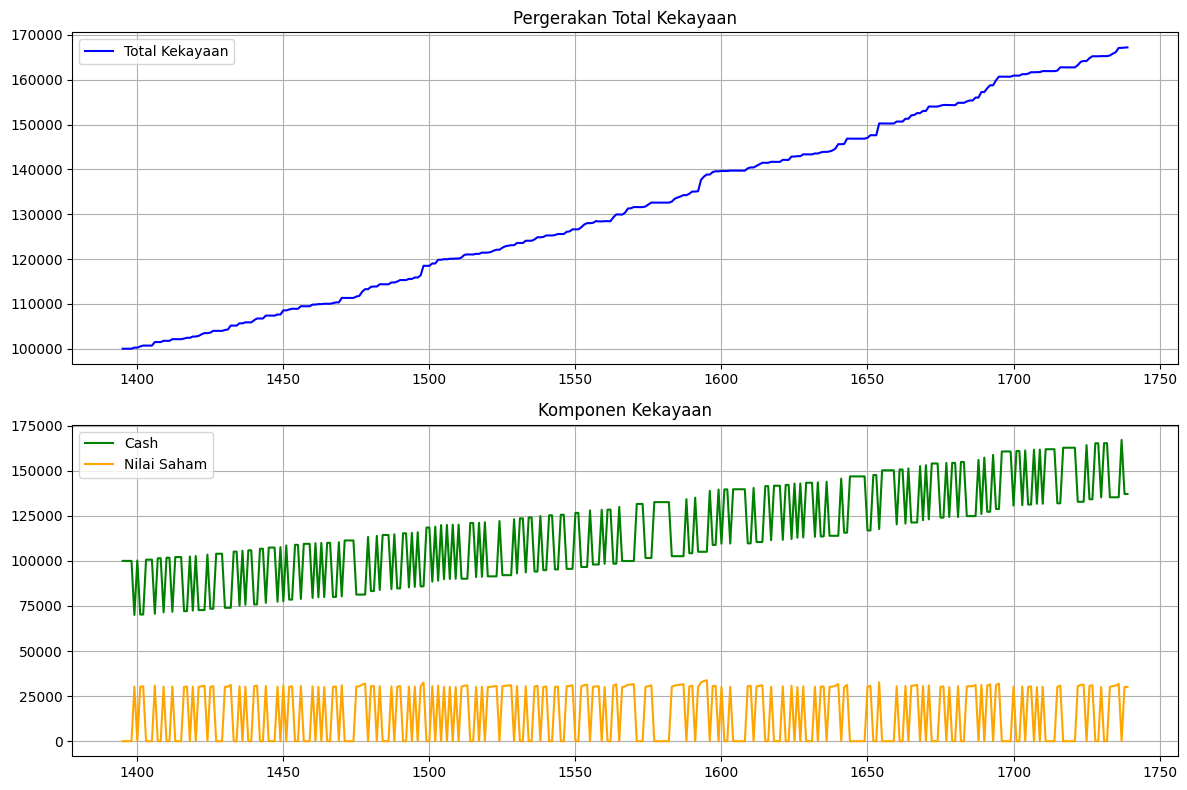


Total Return: 67.21%
Jumlah Transaksi: 190
Total Fee: USD 2,306.51


In [106]:
initial_capital = 100000
transactions, wealth_history, final_value = trading_simulation(hasil_2, initial_capital)

print("\nRiwayat Transaksi:")
print(transactions)
print(f"\nNilai Portfolio Akhir: USD {final_value:,.2f}")

plt.figure(figsize=(12, 8))


plt.subplot(2, 1, 1)
plt.plot(wealth_history['Date'], wealth_history['Wealth'], label='Total Kekayaan', color='blue')
plt.title('Pergerakan Total Kekayaan')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(wealth_history['Date'], wealth_history['Cash'], label='Cash', color='green')
plt.plot(wealth_history['Date'], wealth_history['Stock Value'], label='Nilai Saham', color='orange')
plt.title('Komponen Kekayaan')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

total_return = (final_value - initial_capital) / initial_capital * 100
print(f"\nTotal Return: {total_return:.2f}%")

total_transactions = len(transactions)
total_fees = transactions['Fee'].sum() if not transactions.empty else 0
print(f"Jumlah Transaksi: {total_transactions}")
print(f"Total Fee: USD {total_fees:,.2f}")


# 5. MRO

In [107]:
df_dict['MRO']

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,label,day,...,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
0,2018-01-02 05:00:00+00:00,15.553840,15.808373,15.490207,15.799282,8107020,0.00,0.0,0,2,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
1,2018-01-03 05:00:00+00:00,15.862918,16.244719,15.844736,16.062908,10684677,0.00,0.0,1,3,...,NaN,NaN,NaN,NaN,NaN,0.021030,0.004206,NaN,1.113641,NaN
2,2018-01-04 05:00:00+00:00,16.271989,16.499251,16.020910,16.471981,14052092,0.00,0.0,1,4,...,NaN,NaN,NaN,NaN,NaN,0.069899,0.017345,NaN,0.912201,NaN
3,2018-01-05 05:00:00+00:00,16.326533,16.326533,16.026546,16.262899,11962183,0.00,0.0,0,5,...,NaN,NaN,NaN,NaN,NaN,0.090712,0.032018,NaN,-0.484850,NaN
4,2018-01-08 05:00:00+00:00,16.244721,16.344715,16.044729,16.335625,7096781,0.00,0.0,1,8,...,NaN,NaN,NaN,NaN,NaN,0.111786,0.047972,NaN,0.272732,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1730,2024-11-15 05:00:00+00:00,28.790001,29.059999,28.485001,28.590000,5087537,0.11,0.0,0,15,...,28.461507,1.423977,72.747707,82.534753,74.388152,0.418430,0.249843,-27.252293,0.556522,54.441035
1731,2024-11-18 05:00:00+00:00,28.910000,29.129999,28.719999,28.990000,5382254,0.00,0.0,1,18,...,28.587210,1.584890,92.198951,83.746170,75.726096,0.458343,0.291543,-7.801049,1.317071,137.778152
1732,2024-11-19 05:00:00+00:00,28.750000,29.045000,28.610001,28.750000,4249408,0.00,0.0,0,19,...,28.640461,1.255234,70.233658,82.379701,69.426897,0.465245,0.326283,-29.766342,0.126438,65.864665
1733,2024-11-20 05:00:00+00:00,28.770000,29.000099,28.670000,28.920000,3671800,0.00,0.0,1,20,...,28.701798,0.229811,83.550215,81.583644,55.210569,0.478912,0.356809,-16.449785,0.757649,107.203834


In [108]:
X_train = df_dict['MRO'].dropna(subset=features)
split_fraction = 0.8
split_index = int(len(X_train) * split_fraction)
train_set = X_train.iloc[:split_index]
test_set = X_train.iloc[split_index:]

In [109]:
test_set

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,label,day,...,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
1391,2023-07-14 04:00:00+00:00,24.298957,24.333098,23.377138,23.489317,13302313,0.00,0.0,0,14,...,23.480094,1.121792,63.418279,79.512712,63.658003,0.349145,0.126023,-36.581721,-0.188775,34.405656
1392,2023-07-17 04:00:00+00:00,23.460052,23.577109,23.266520,23.372259,12427270,0.00,0.0,0,17,...,23.524256,0.916941,59.820031,78.789517,61.084915,0.338114,0.168441,-40.179969,0.282662,15.824325
1393,2023-07-18 04:00:00+00:00,23.352751,24.406259,23.303977,24.191654,12989139,0.00,0.0,1,18,...,23.700727,1.755844,85.007475,79.455206,67.786568,0.390983,0.212950,-14.992525,0.938054,84.763365
1394,2023-07-19 04:00:00+00:00,24.103862,24.562334,24.016072,24.259939,10726747,0.00,0.0,1,19,...,23.857689,1.921680,87.106492,81.018111,69.582589,0.433397,0.257039,-12.893508,0.678575,76.190668
1395,2023-07-20 04:00:00+00:00,24.562330,24.679386,24.312902,24.611103,10775029,0.00,0.0,1,20,...,24.043560,2.624006,97.535092,86.065707,76.739521,0.489701,0.303571,-2.464908,1.144515,101.234159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1730,2024-11-15 05:00:00+00:00,28.790001,29.059999,28.485001,28.590000,5087537,0.11,0.0,0,15,...,28.461507,1.423977,72.747707,82.534753,74.388152,0.418430,0.249843,-27.252293,0.556522,54.441035
1731,2024-11-18 05:00:00+00:00,28.910000,29.129999,28.719999,28.990000,5382254,0.00,0.0,1,18,...,28.587210,1.584890,92.198951,83.746170,75.726096,0.458343,0.291543,-7.801049,1.317071,137.778152
1732,2024-11-19 05:00:00+00:00,28.750000,29.045000,28.610001,28.750000,4249408,0.00,0.0,0,19,...,28.640461,1.255234,70.233658,82.379701,69.426897,0.465245,0.326283,-29.766342,0.126438,65.864665
1733,2024-11-20 05:00:00+00:00,28.770000,29.000099,28.670000,28.920000,3671800,0.00,0.0,1,20,...,28.701798,0.229811,83.550215,81.583644,55.210569,0.478912,0.356809,-16.449785,0.757649,107.203834


In [110]:
ChoosenFeature = ['A/D_Oscillator', 'Stochastic_K', 'Stochastic_D', 'MACD_Signal', 'day_of_week', 'Close', 'Low', 'High', 'SMA', 'WMA', 'Volume']

In [111]:
y_train_MRO = train_set['label']  
X_train_MRO = train_set.drop(columns=['label','Date','Dividends','Stock Splits'])
X_train_MRO  = X_train_MRO[ChoosenFeature]

In [112]:
y_test_MRO = test_set['label']  
X_test_MRO = test_set.drop(columns=['label','Date','Dividends','Stock Splits'])
X_test_MRO  = X_test_MRO[ChoosenFeature]

In [113]:
X_train_MRO

,A/D_Oscillator,Stochastic_K,Stochastic_D,MACD_Signal,day_of_week,Close,Low,High,SMA,WMA,Volume
18,0.410712,37.931087,69.839092,0.322505,0,16.926508,16.826512,17.335579,17.114679,17.159388,7613634
19,-0.166671,19.337009,65.511056,0.308782,1,16.417437,16.099269,16.808328,17.098317,17.032617,12467494
20,0.727278,26.519493,59.405244,0.288178,2,16.535616,16.335624,16.635610,17.039228,16.930308,9760274
21,0.916660,39.779035,55.854569,0.267164,3,16.753786,16.508342,16.835601,17.015593,16.878409,9494424
22,-0.246944,4.757424,49.592720,0.233189,4,15.926552,15.835737,16.571976,16.919234,16.680402,10885077
...,...,...,...,...,...,...,...,...,...,...,...
1386,0.937980,87.830715,46.588386,-0.130381,4,22.943052,21.909053,23.167410,22.091467,22.293745,18665769
1387,0.495729,99.481854,56.136571,-0.100739,0,23.216185,22.655290,23.225940,22.271930,22.498239,12628705
1388,1.235771,91.417929,63.939087,-0.056737,1,23.733183,23.357627,23.957541,22.483607,22.763921,14668731
1389,1.488376,94.136667,72.236678,0.001246,2,24.181900,23.938033,24.357483,22.745033,23.072702,12062215


In [114]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(C=10, penalty='l1', solver='liblinear'))
])

pipeline.fit(X_train_MRO, y_train_MRO)


y_pred = pipeline.predict(X_test_MRO)

accuracy = accuracy_score(y_test_MRO, y_pred)
precision = precision_score(y_test_MRO, y_pred)
recall = recall_score(y_test_MRO, y_pred)
f1 = f1_score(y_test_MRO, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.9709302325581395
Precision: 0.9831460674157303
Recall: 0.9615384615384616
F1 Score: 0.9722222222222222


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Menggunakan data test sebagai backtest

In [115]:
hasil = test_set.copy()
hasil['Predict_Label'] = y_pred
print(hasil)

                          Date       Open       High        Low      Close  \
1391 2023-07-14 04:00:00+00:00  24.298957  24.333098  23.377138  23.489317   
1392 2023-07-17 04:00:00+00:00  23.460052  23.577109  23.266520  23.372259   
1393 2023-07-18 04:00:00+00:00  23.352751  24.406259  23.303977  24.191654   
1394 2023-07-19 04:00:00+00:00  24.103862  24.562334  24.016072  24.259939   
1395 2023-07-20 04:00:00+00:00  24.562330  24.679386  24.312902  24.611103   
...                        ...        ...        ...        ...        ...   
1730 2024-11-15 05:00:00+00:00  28.790001  29.059999  28.485001  28.590000   
1731 2024-11-18 05:00:00+00:00  28.910000  29.129999  28.719999  28.990000   
1732 2024-11-19 05:00:00+00:00  28.750000  29.045000  28.610001  28.750000   
1733 2024-11-20 05:00:00+00:00  28.770000  29.000099  28.670000  28.920000   
1734 2024-11-21 05:00:00+00:00  29.090000  29.370001  28.430000  28.549999   

        Volume  Dividends  Stock Splits  label  day  ...  Momen

### Label asli VS Prediction

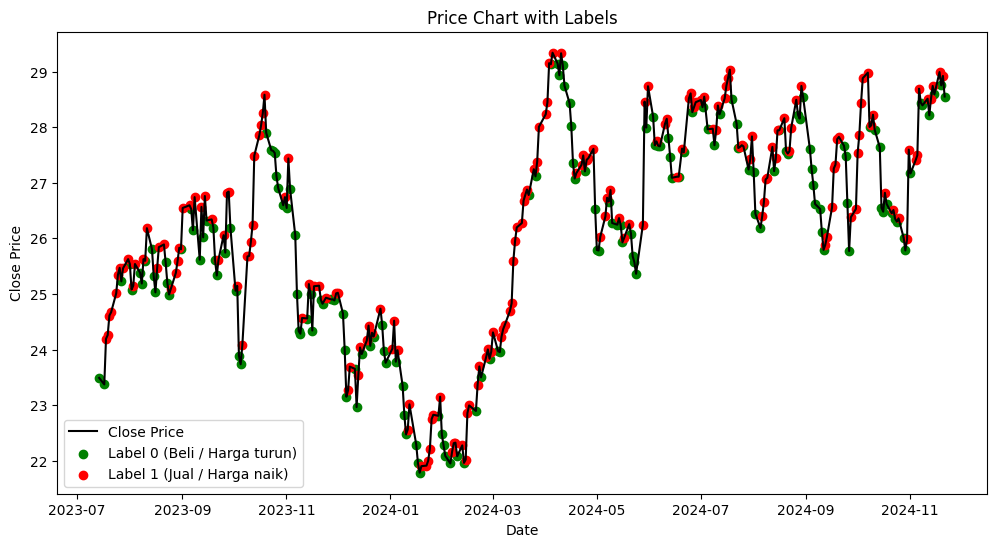

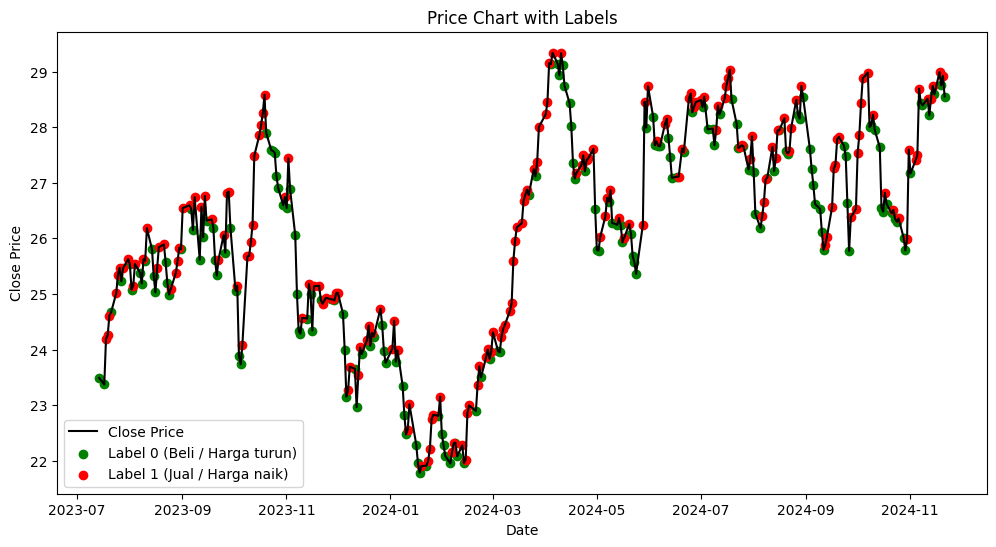

In [116]:
gambar(hasil)
gambar(hasil,'Predict_Label')

## Transform into local minima/maxima

In [117]:
for i in range(len(y_pred)-1):
    if y_pred[i] == y_pred[i+1]:
        y_pred[i] = 2 # hold

### Predict Label vs Local Maxima/Minima

                          Date       Open       High        Low      Close  \
1391 2023-07-14 04:00:00+00:00  24.298957  24.333098  23.377138  23.489317   
1392 2023-07-17 04:00:00+00:00  23.460052  23.577109  23.266520  23.372259   
1393 2023-07-18 04:00:00+00:00  23.352751  24.406259  23.303977  24.191654   
1394 2023-07-19 04:00:00+00:00  24.103862  24.562334  24.016072  24.259939   
1395 2023-07-20 04:00:00+00:00  24.562330  24.679386  24.312902  24.611103   
...                        ...        ...        ...        ...        ...   
1730 2024-11-15 05:00:00+00:00  28.790001  29.059999  28.485001  28.590000   
1731 2024-11-18 05:00:00+00:00  28.910000  29.129999  28.719999  28.990000   
1732 2024-11-19 05:00:00+00:00  28.750000  29.045000  28.610001  28.750000   
1733 2024-11-20 05:00:00+00:00  28.770000  29.000099  28.670000  28.920000   
1734 2024-11-21 05:00:00+00:00  29.090000  29.370001  28.430000  28.549999   

        Volume  Dividends  Stock Splits  label  day  ...  Momen

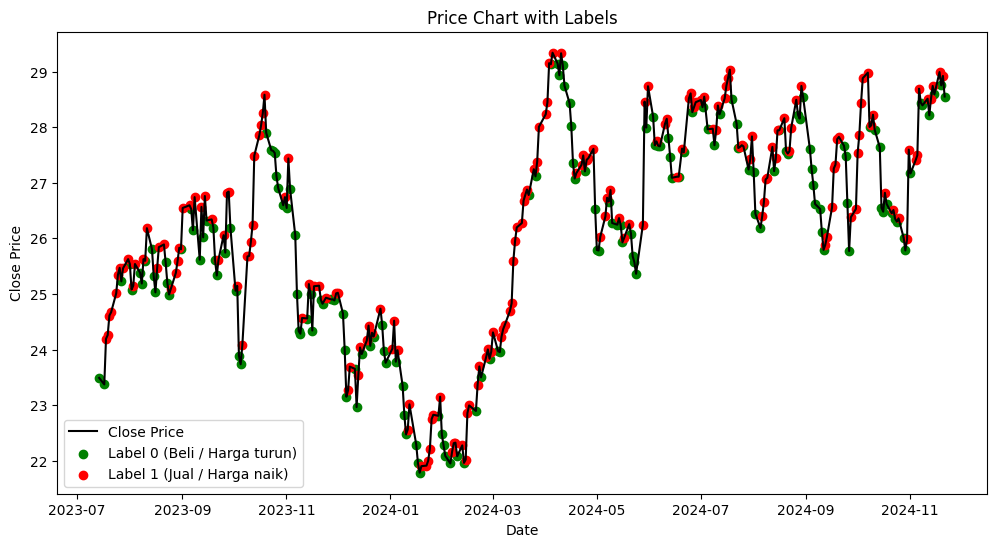

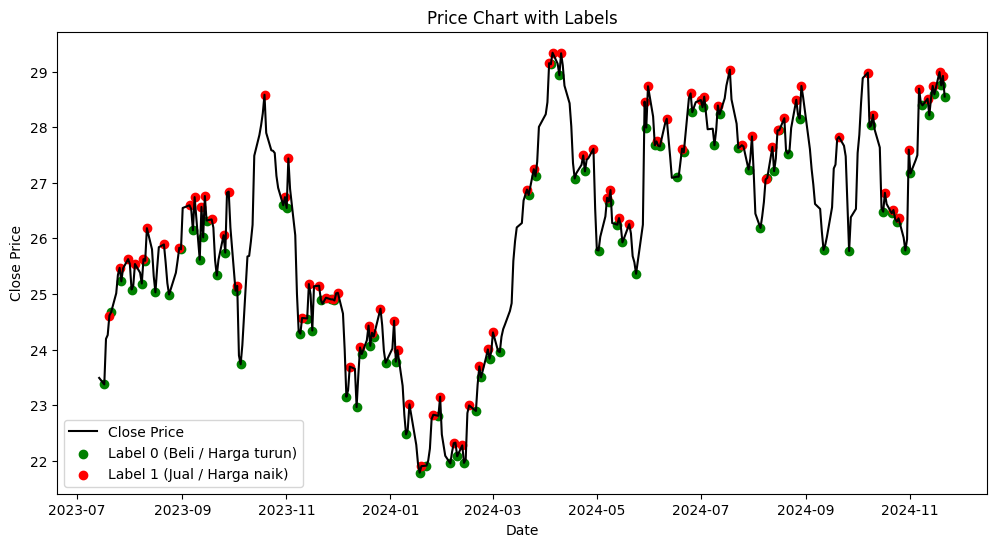

In [118]:
hasil_2 = test_set.copy()
hasil_2['Predict_Label'] = y_pred
print(hasil_2)
gambar(hasil_2)
gambar(hasil_2,'Predict_Label')

## Backtesting Algorithm

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def trading_simulation(df, initial_capital=100000):
    capital = initial_capital
    shares = 0
    transactions = []
    wealth_history = []
    fee_rate = 0.0004  # 0.04%
    
    for i in range(len(df)):
        current_price =  df['Close'].iloc[i]
        action = df['Predict_Label'].iloc[i]
        
        total_wealth = capital + (shares * current_price)
        wealth_history.append({
            'Date': df.index[i],
            'Wealth': total_wealth,
            'Cash': capital,
            'Stock Value': shares * current_price
        })
        
        if action == 0:  # Beli
            buy_amount = initial_capital * 0.3  # 30% dari modal awal
            if capital >= buy_amount:
                shares_to_buy = (buy_amount // current_price)
                cost = shares_to_buy * current_price
                fee = cost * fee_rate
                total_cost = cost + fee
                
                if total_cost <= capital:
                    capital -= total_cost
                    shares += shares_to_buy
                    transactions.append({
                        'Date': df.index[i],
                        'Action': 'Beli',
                        'Shares': shares_to_buy,
                        'Price': current_price,
                        'Cost': cost,
                        'Fee': fee,
                        'Total Cost': total_cost,
                        'Remaining Capital': capital,
                        'Total Shares': shares
                    })
                
        elif action == 1:  # Jual
            if shares > 0:
                revenue = shares * current_price
                fee = revenue * fee_rate
                net_revenue = revenue - fee
                capital += net_revenue
                transactions.append({
                    'Date': df.index[i],
                    'Action': 'Jual',
                    'Shares': shares,
                    'Price': current_price,
                    'Revenue': revenue,
                    'Fee': fee,
                    'Net Revenue': net_revenue,
                    'Remaining Capital': capital,
                    'Total Shares': 0
                })
                shares = 0
    
    final_portfolio_value = capital + (shares * df['Close'].iloc[-1])
    
    return (pd.DataFrame(transactions), 
            pd.DataFrame(wealth_history), 
            final_portfolio_value)


In [121]:
hasil_2

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,label,day,...,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI,Predict_Label
1391,2023-07-14 04:00:00+00:00,24.298957,24.333098,23.377138,23.489317,13302313,0.00,0.0,0,14,...,1.121792,63.418279,79.512712,63.658003,0.349145,0.126023,-36.581721,-0.188775,34.405656,2
1392,2023-07-17 04:00:00+00:00,23.460052,23.577109,23.266520,23.372259,12427270,0.00,0.0,0,17,...,0.916941,59.820031,78.789517,61.084915,0.338114,0.168441,-40.179969,0.282662,15.824325,0
1393,2023-07-18 04:00:00+00:00,23.352751,24.406259,23.303977,24.191654,12989139,0.00,0.0,1,18,...,1.755844,85.007475,79.455206,67.786568,0.390983,0.212950,-14.992525,0.938054,84.763365,2
1394,2023-07-19 04:00:00+00:00,24.103862,24.562334,24.016072,24.259939,10726747,0.00,0.0,1,19,...,1.921680,87.106492,81.018111,69.582589,0.433397,0.257039,-12.893508,0.678575,76.190668,2
1395,2023-07-20 04:00:00+00:00,24.562330,24.679386,24.312902,24.611103,10775029,0.00,0.0,1,20,...,2.624006,97.535092,86.065707,76.739521,0.489701,0.303571,-2.464908,1.144515,101.234159,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1730,2024-11-15 05:00:00+00:00,28.790001,29.059999,28.485001,28.590000,5087537,0.11,0.0,0,15,...,1.423977,72.747707,82.534753,74.388152,0.418430,0.249843,-27.252293,0.556522,54.441035,0
1731,2024-11-18 05:00:00+00:00,28.910000,29.129999,28.719999,28.990000,5382254,0.00,0.0,1,18,...,1.584890,92.198951,83.746170,75.726096,0.458343,0.291543,-7.801049,1.317071,137.778152,1
1732,2024-11-19 05:00:00+00:00,28.750000,29.045000,28.610001,28.750000,4249408,0.00,0.0,0,19,...,1.255234,70.233658,82.379701,69.426897,0.465245,0.326283,-29.766342,0.126438,65.864665,0
1733,2024-11-20 05:00:00+00:00,28.770000,29.000099,28.670000,28.920000,3671800,0.00,0.0,1,20,...,0.229811,83.550215,81.583644,55.210569,0.478912,0.356809,-16.449785,0.757649,107.203834,1



Riwayat Transaksi:
     Date Action  Shares      Price          Cost        Fee    Total Cost  \
0    1392   Beli  1283.0  23.372259  29986.608477  11.994643  29998.603120   
1    1395   Jual  1283.0  24.611103           NaN  12.630418           NaN   
2    1396   Beli  1216.0  24.669634  29998.274780  11.999310  30010.274090   
3    1399   Jual  1216.0  25.469521           NaN  12.388375           NaN   
4    1400   Beli  1189.0  25.225653  29993.301054  11.997320  30005.298374   
..    ...    ...     ...        ...           ...        ...           ...   
162  1730   Beli  1049.0  28.590000  29990.910160  11.996364  30002.906524   
163  1731   Jual  1049.0  28.990000           NaN  12.164204           NaN   
164  1732   Beli  1043.0  28.750000  29986.250000  11.994500  29998.244500   
165  1733   Jual  1043.0  28.920000           NaN  12.065424           NaN   
166  1734   Beli  1050.0  28.549999  29977.499199  11.991000  29989.490199   

     Remaining Capital  Total Shares       

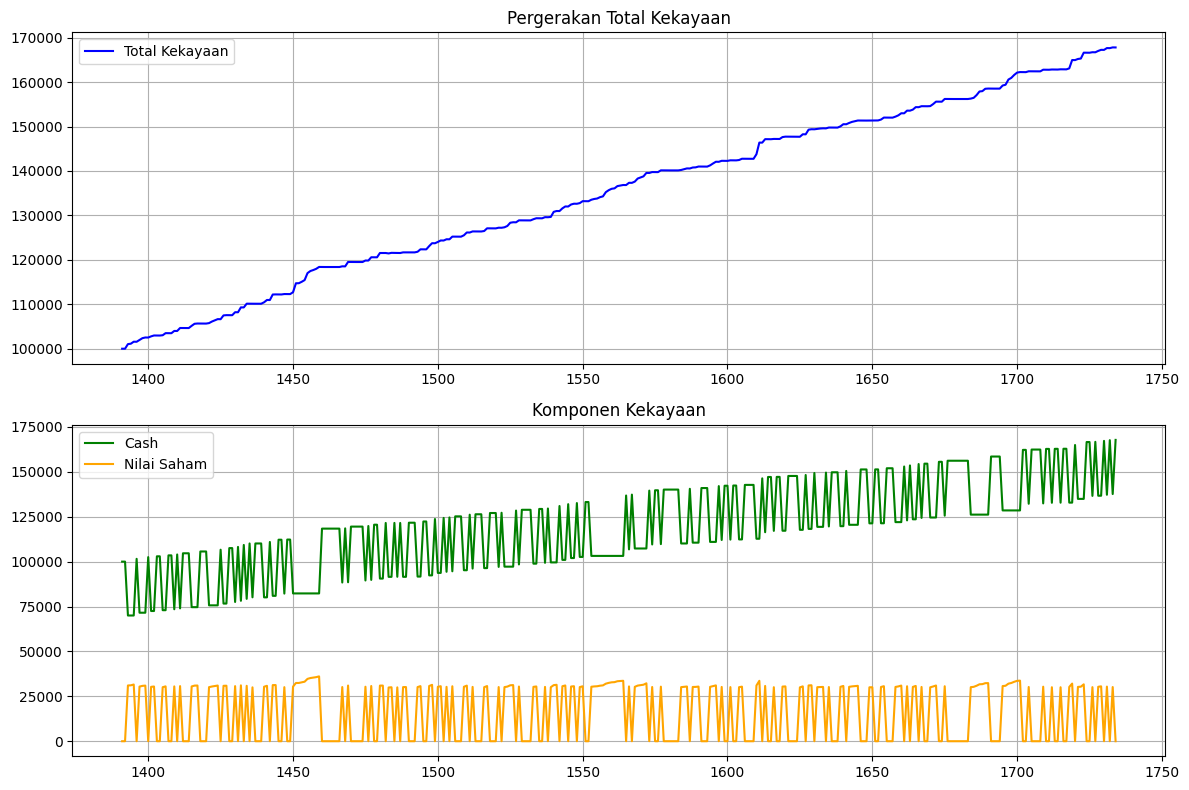


Total Return: 67.78%
Jumlah Transaksi: 167
Total Fee: USD 2,031.11


In [122]:
initial_capital = 100000
transactions, wealth_history, final_value = trading_simulation(hasil_2, initial_capital)

print("\nRiwayat Transaksi:")
print(transactions)
print(f"\nNilai Portfolio Akhir: USD {final_value:,.2f}")

plt.figure(figsize=(12, 8))


plt.subplot(2, 1, 1)
plt.plot(wealth_history['Date'], wealth_history['Wealth'], label='Total Kekayaan', color='blue')
plt.title('Pergerakan Total Kekayaan')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(wealth_history['Date'], wealth_history['Cash'], label='Cash', color='green')
plt.plot(wealth_history['Date'], wealth_history['Stock Value'], label='Nilai Saham', color='orange')
plt.title('Komponen Kekayaan')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

total_return = (final_value - initial_capital) / initial_capital * 100
print(f"\nTotal Return: {total_return:.2f}%")

total_transactions = len(transactions)
total_fees = transactions['Fee'].sum() if not transactions.empty else 0
print(f"Jumlah Transaksi: {total_transactions}")
print(f"Total Fee: USD {total_fees:,.2f}")
